# Showcase of Average Rating & Number of Rating Trends by Main Category

## Setting Up

In [132]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import json

# Initialize empty lists to store data
parent_asin_list = []
time_period_list = []
average_rating_list = []
rating_count_list = []

# Read the document file line-by-line
with open('output_Temporal_Trends_All/part-r-00000-TTA', 'r') as file:
    for line in file:
        # Use regex to extract data from each line
        match = re.search(r'"parent_asin":(\S+), "time_period":(\S+)\s+"average_rating":(\d+\.\d+), "rating_count":(\d+)', line)
        if match:
            parent_asin_list.append(match.group(1))
            time_period_list.append(match.group(2))
            average_rating_list.append(float(match.group(3)))
            rating_count_list.append(int(match.group(4)))

# Create DataFrame from the extracted data
df = pd.DataFrame({
    'parent_asin': parent_asin_list,
    'time_period': time_period_list,
    'average_rating': average_rating_list,
    'rating_count': rating_count_list
})

# Convert time_period to datetime and extract the year
df['year'] = pd.to_datetime(df['time_period']).dt.year

# Filter for data between 2022 and 2023
filtered_df = df[(df['year'] >= 2019) & (df['year'] <= 2023)]

filtered_df = filtered_df.sort_values(by=['rating_count'], ascending=False)

trends_df = filtered_df.copy()

print(trends_df.head())

        parent_asin time_period  average_rating  rating_count  year
1272341  B0BN942894     2021-03            4.50          1300  2021
911081   B07DK1H3H5     2020-12            2.31          1229  2020
1272338  B0BN942894     2020-12            4.71          1006  2020
1272339  B0BN942894     2021-01            4.59           994  2021
1233545  B09XM8MMYD     2022-01            4.33           877  2022


In [ ]:
# Path to your MapReduce output file
file_path = 'output_Clean_Main_Category/part-r-00000'

# Initialize empty lists to store data
categories = []
counts = []
total_ratings = []
avg_ratings = []
parent_asins = []

# Read the file and parse each line
with open(file_path, 'r') as file:
    for line in file:
        # MapReduce output is typically in format: key\tvalue
        parts = line.strip().split('\t')
        if len(parts) == 2:
            category = parts[0]
            try:
                # Parse the JSON value
                data = json.loads(parts[1])
                
                # Extract fields
                categories.append(category)
                counts.append(data['count'])
                total_ratings.append(data['total_rating_number'])
                avg_ratings.append(data['average_rating'])
                parent_asins.append(data['parent_asin'])
                
            except json.JSONDecodeError:
                print(f"Error parsing JSON in line: {line}")

# Create DataFrame
df = pd.DataFrame({
    'main_category': categories,
    'count': counts,
    'total_rating_number': total_ratings,
    'average_rating': avg_ratings,
    'parent_asin': parent_asins
})

# Sort by count if needed
df_sorted = df.sort_values(by='count', ascending=False)

meta_df = df_sorted.copy()

print(meta_df.head())

                main_category  count  total_rating_number  average_rating  \
35                Video Games  81255             17882290        3.945943   
16                  Computers  17235              6277994        4.076204   
2             All Electronics  14816              4570555        4.096252   
28                     Others  11036               883422        3.938593   
14  Cell Phones & Accessories   3884               669375        4.112565   

                                          parent_asin  
35  [B001RNO1LI, B07Y8NXJ83, B0002B90SU, B00YARF1S...  
16  [B0000DG9SJ, B081ZPYLRZ, B079MB4RNY, B01MDNSQO...  
2   [B083GHBS6B, B0C5X97746, B088ZG6Q82, B00GTAUAS...  
28  [B0BBTN59KL, B08PS16SZY, B0017GHAWW, B01MRXIZC...  
14  [B07TNR1SLB, B0827RCY2Q, B08SC7DGQ3, B08YRBBRN...  


In [133]:
# Step 1: Flatten meta_df's 'parent_asin' column
meta_df_flat = meta_df.explode('parent_asin')

# Step 2: Merge trends_df with meta_df_flat on 'parent_asin' to assign main_category to each product
merged_df = pd.merge(trends_df, meta_df_flat[['parent_asin', 'main_category']], on='parent_asin', how='left')

# Step 3: Group by main_category and time_period, and aggregate the data
agg_df = merged_df.groupby(['main_category', 'time_period']).agg(
    average_rating=('average_rating', 'mean'),
    rating_count=('rating_count', 'sum')
).reset_index()

# Step 4: Visualize the data for each main_category separately
unique_categories = agg_df['main_category'].unique()

# Define month names for X-axis
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Step 1: Extract the month from 'time_period'
agg_df['month'] = pd.to_datetime(agg_df['time_period']).dt.month_name().str[:3]  # Extract month as abbreviated name

# Step 2: Extract year from 'time_period' column
agg_df['year'] = pd.to_datetime(agg_df['time_period']).dt.year


## Display Monthly Average Rating & Rating Numbers per Main Category for a Year

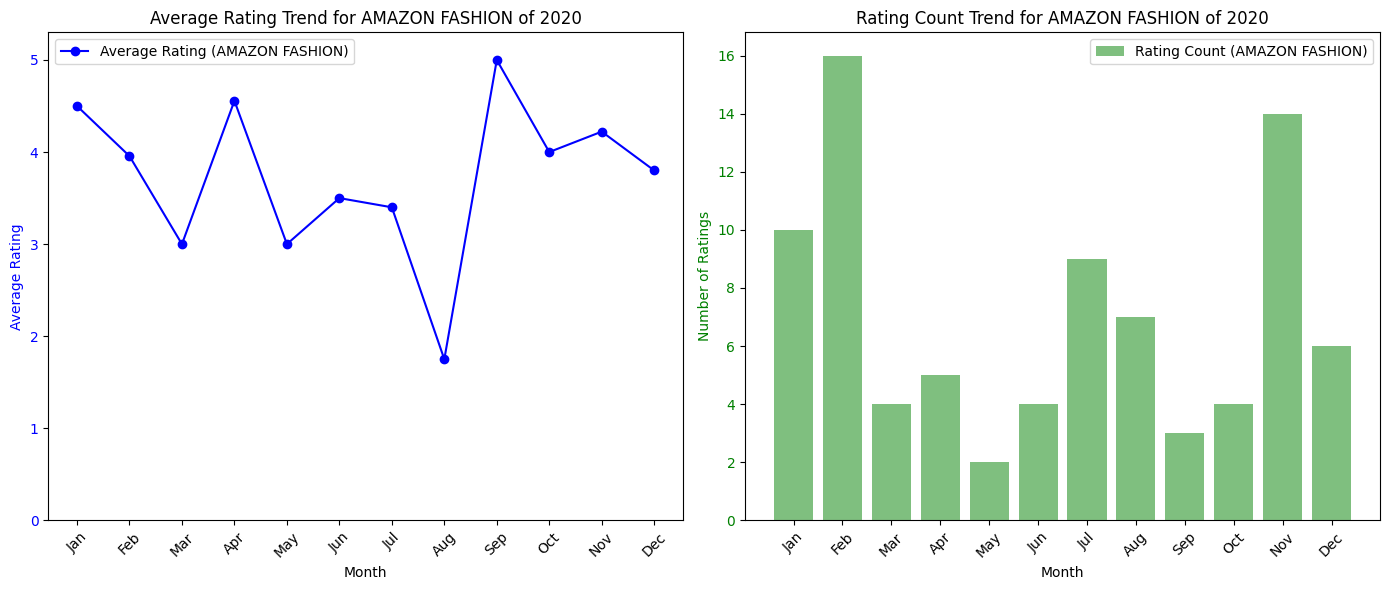

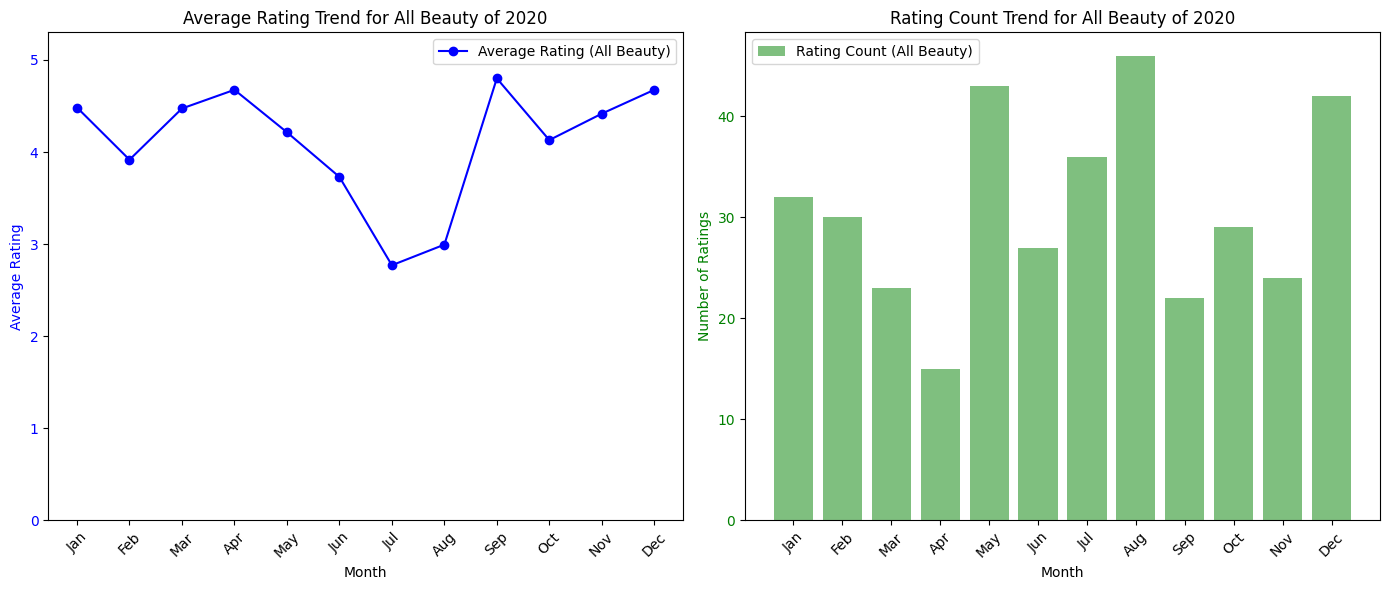

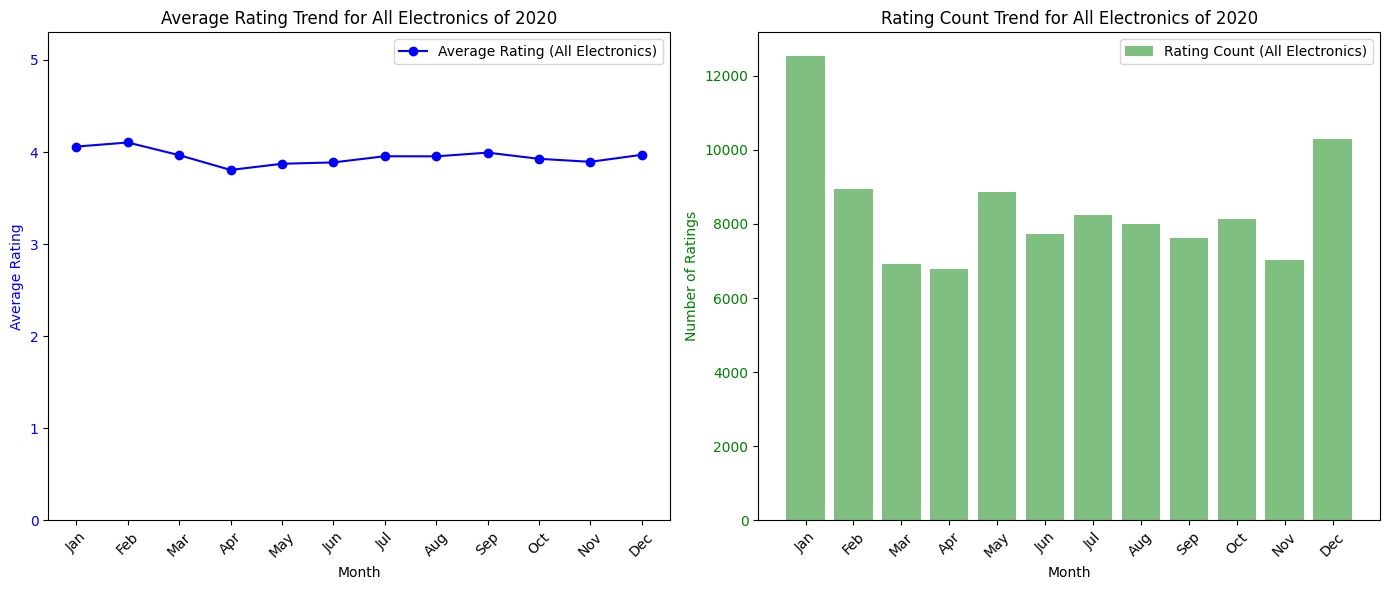

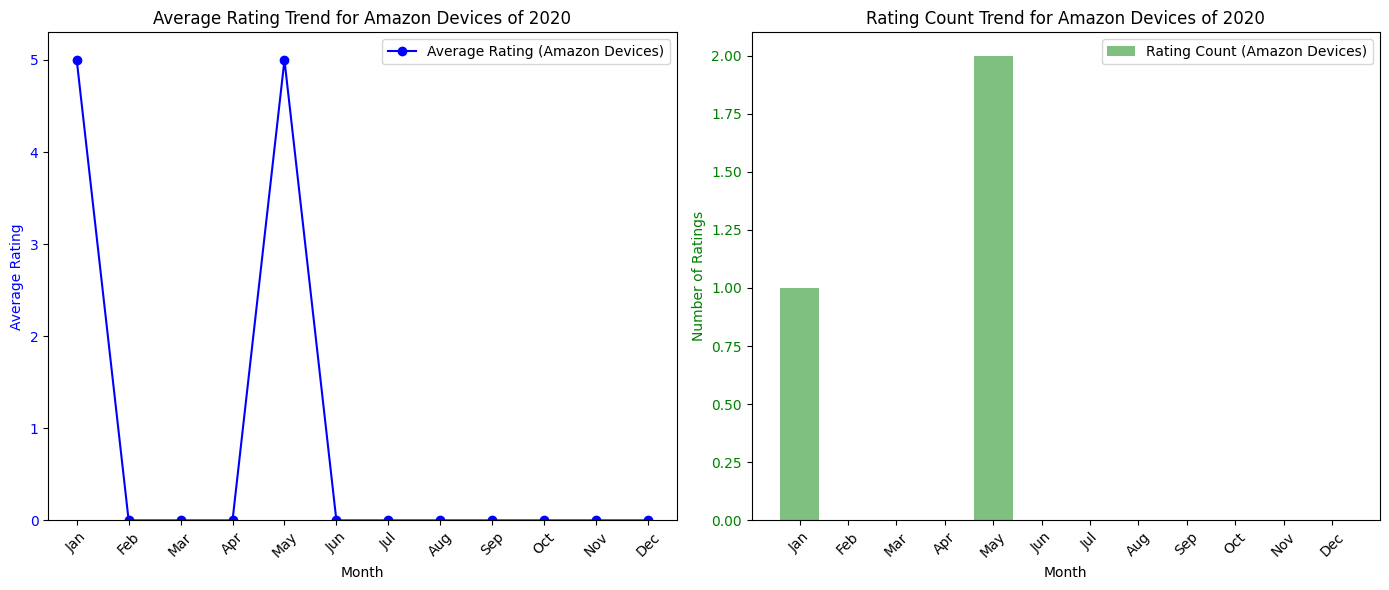

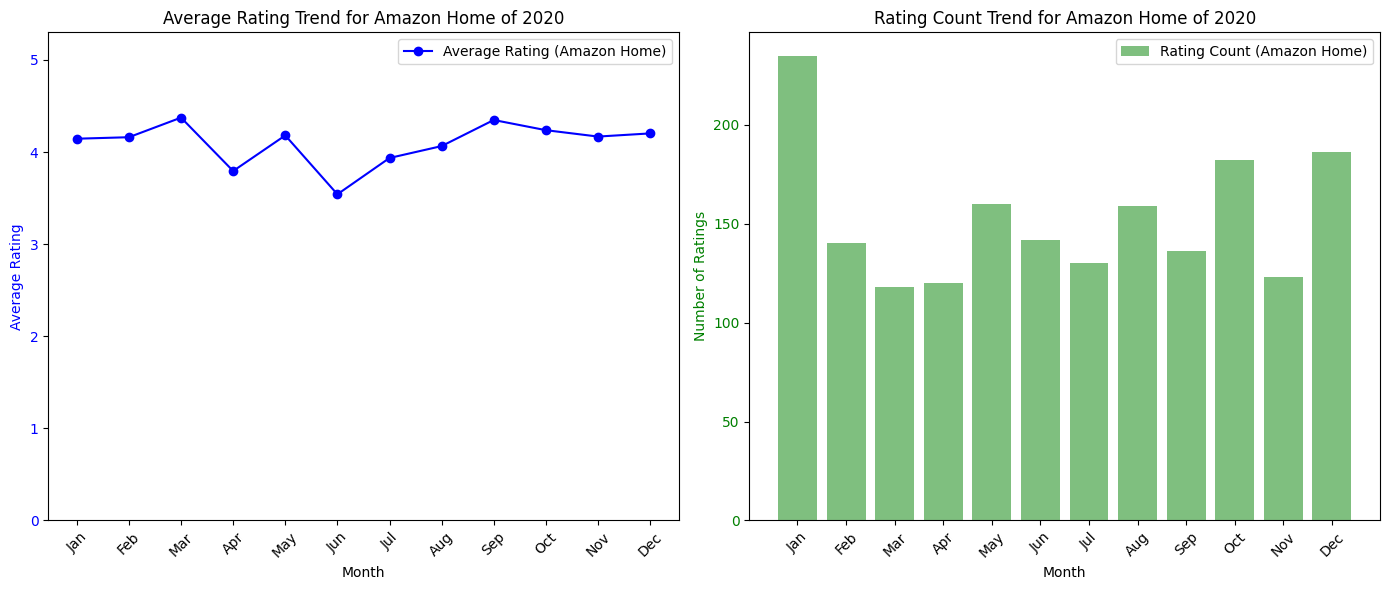

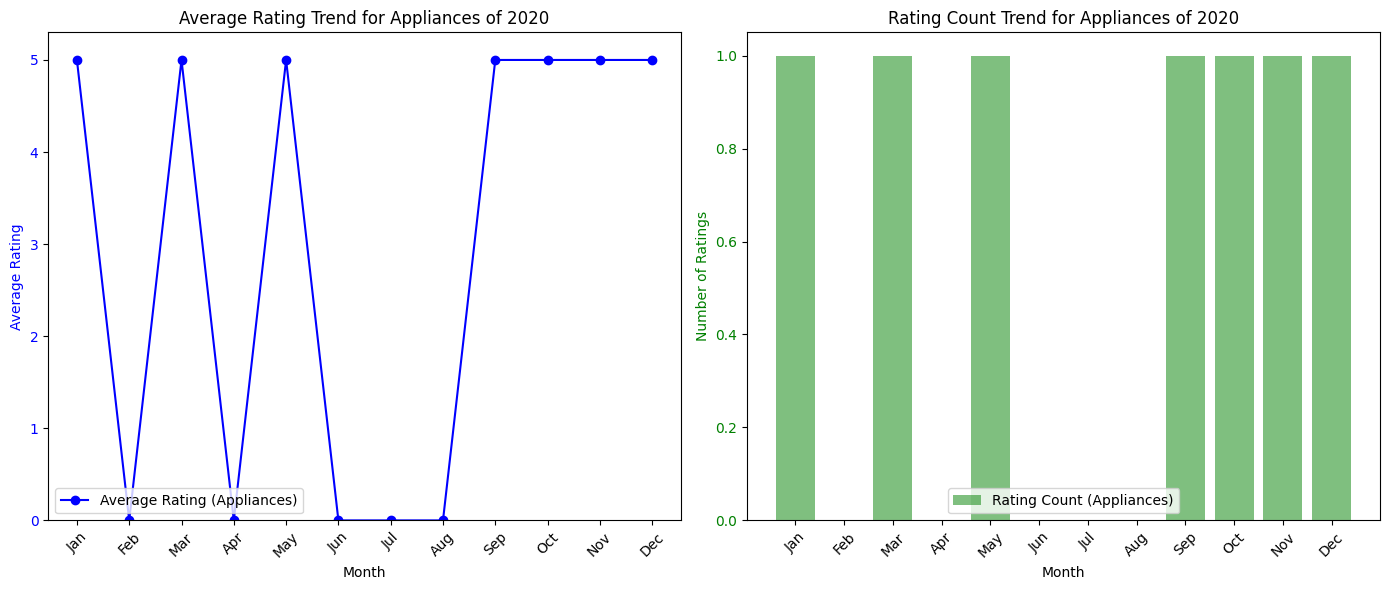

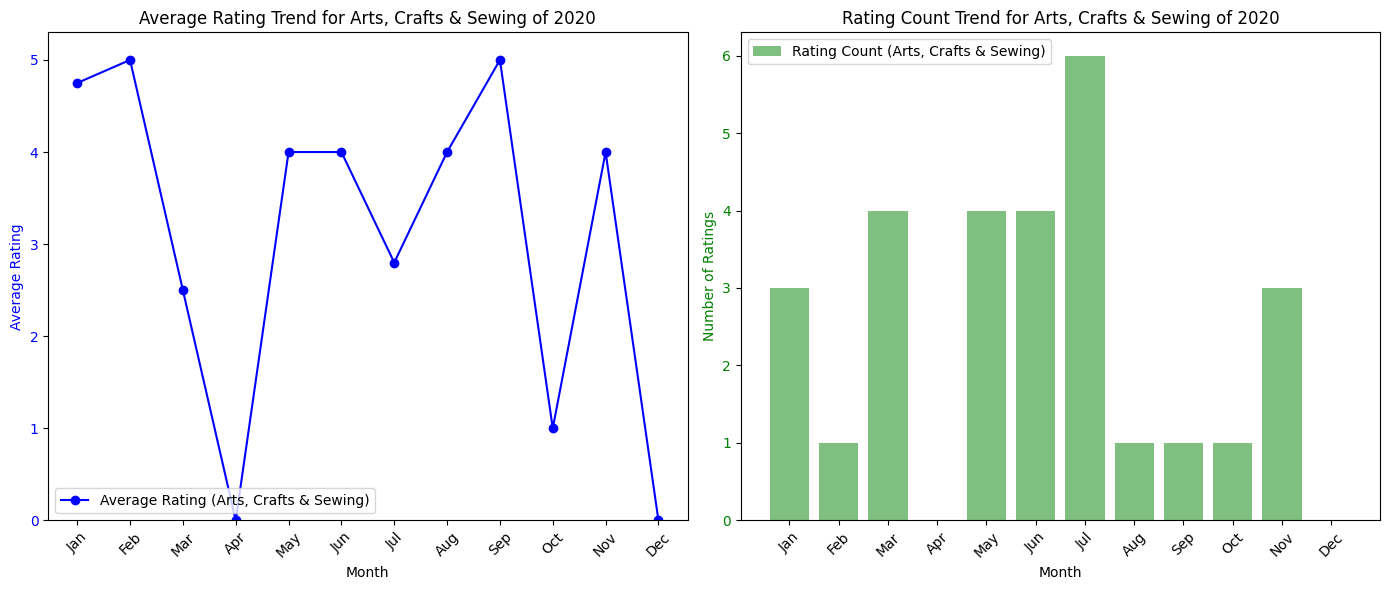

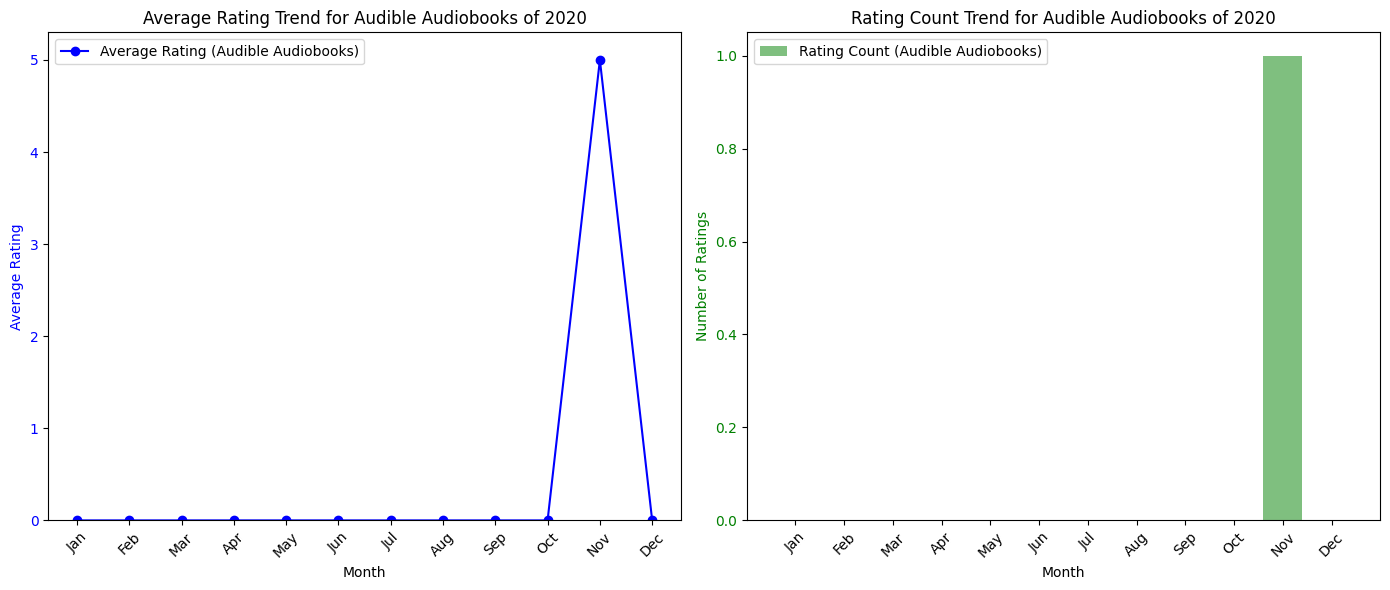

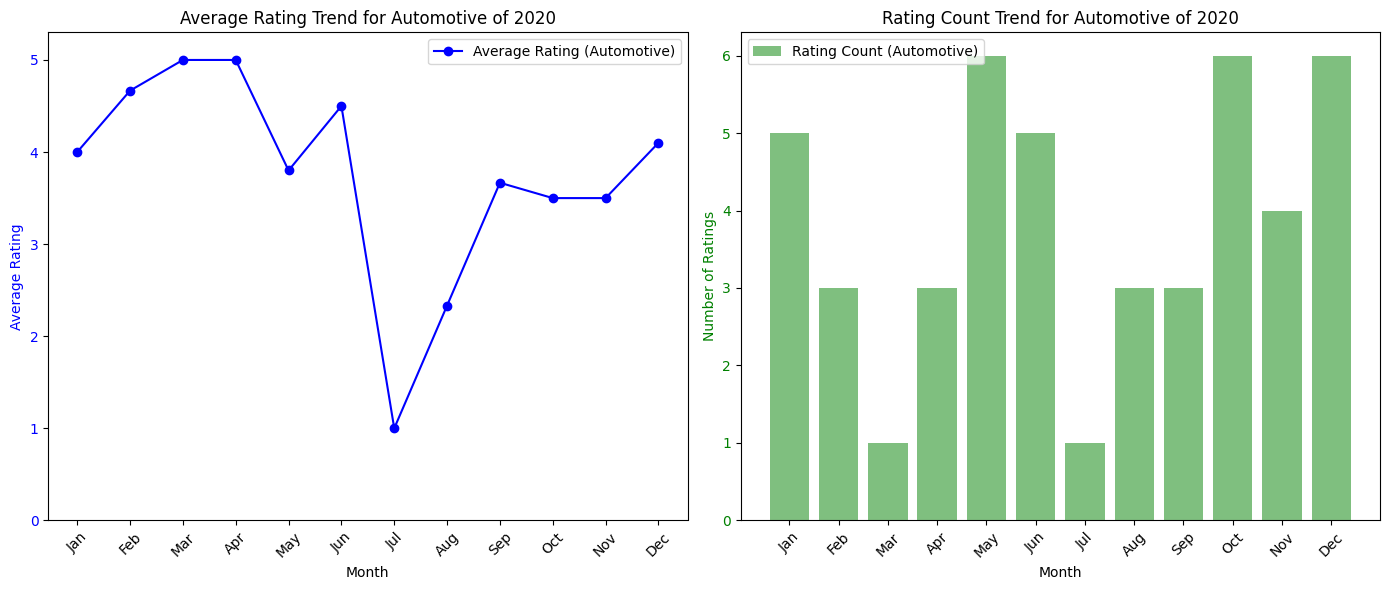

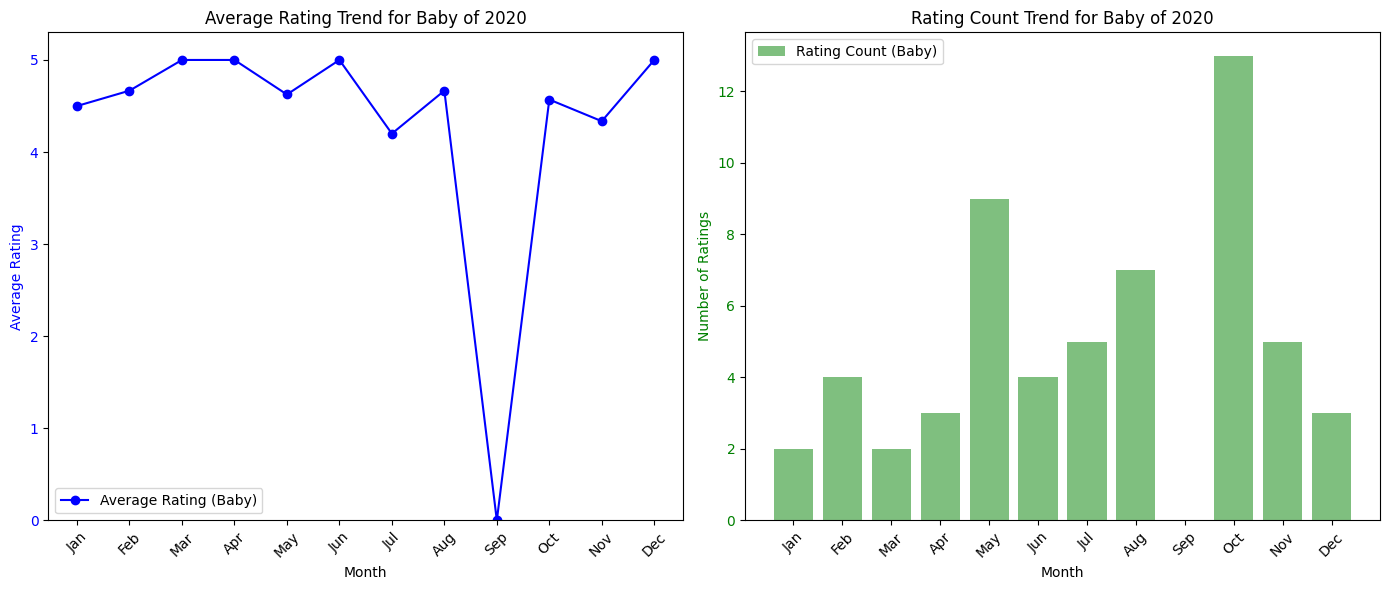

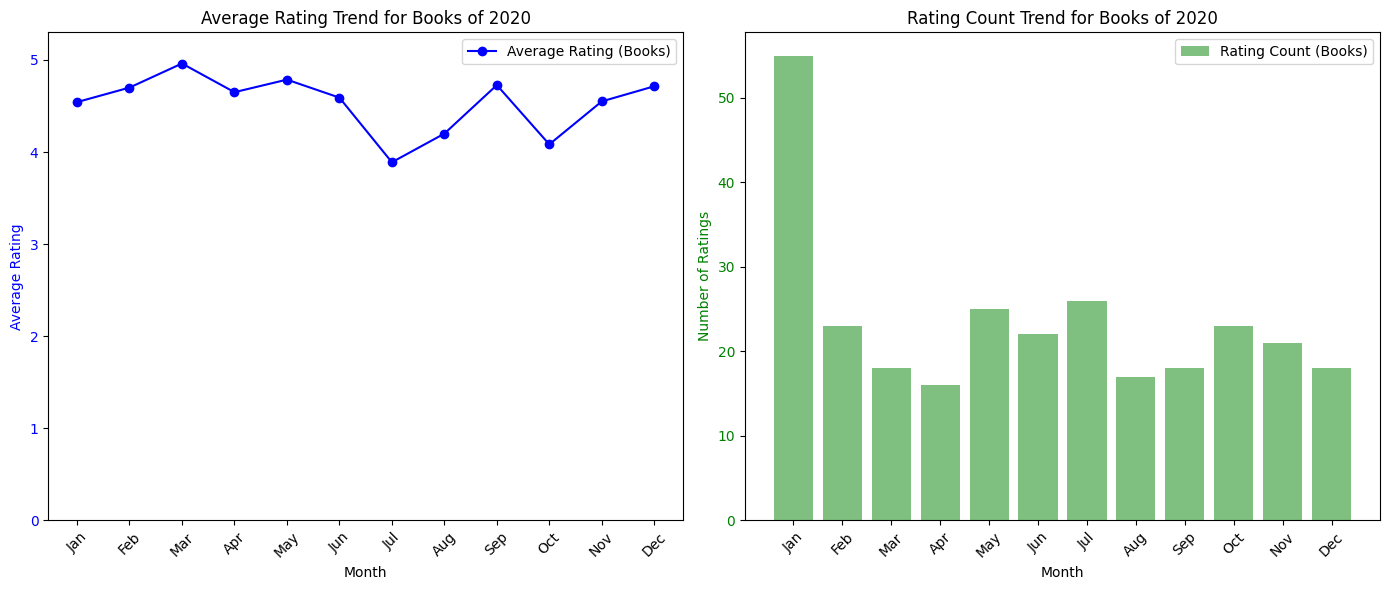

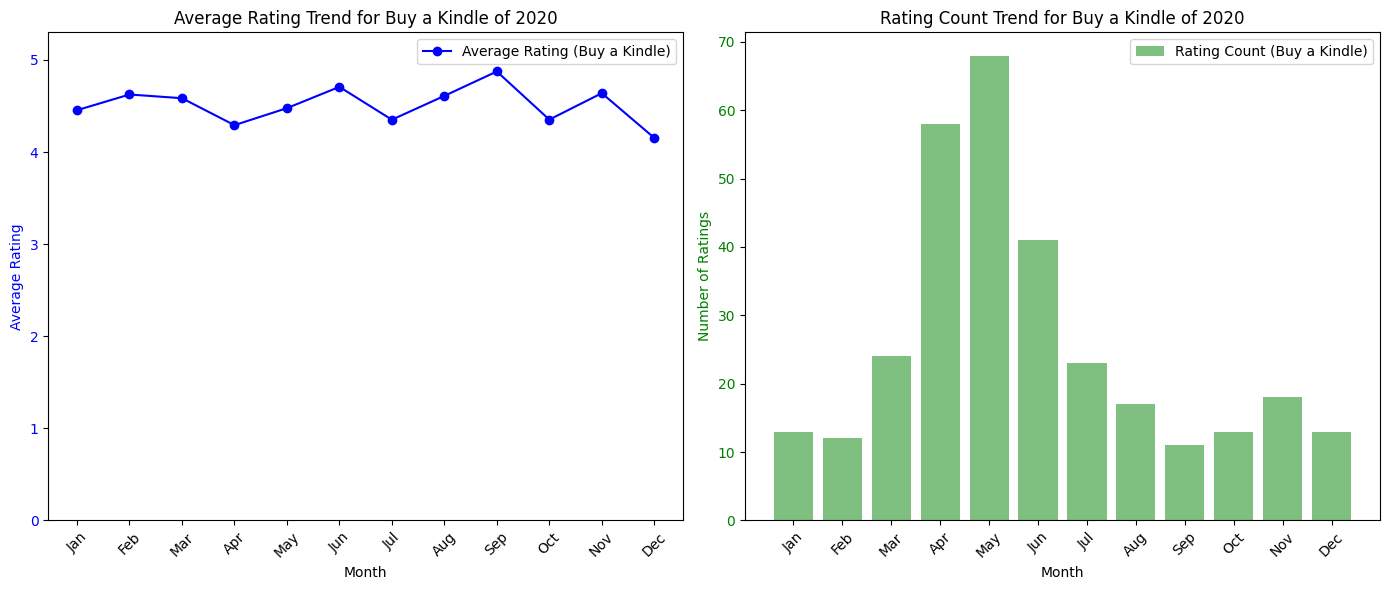

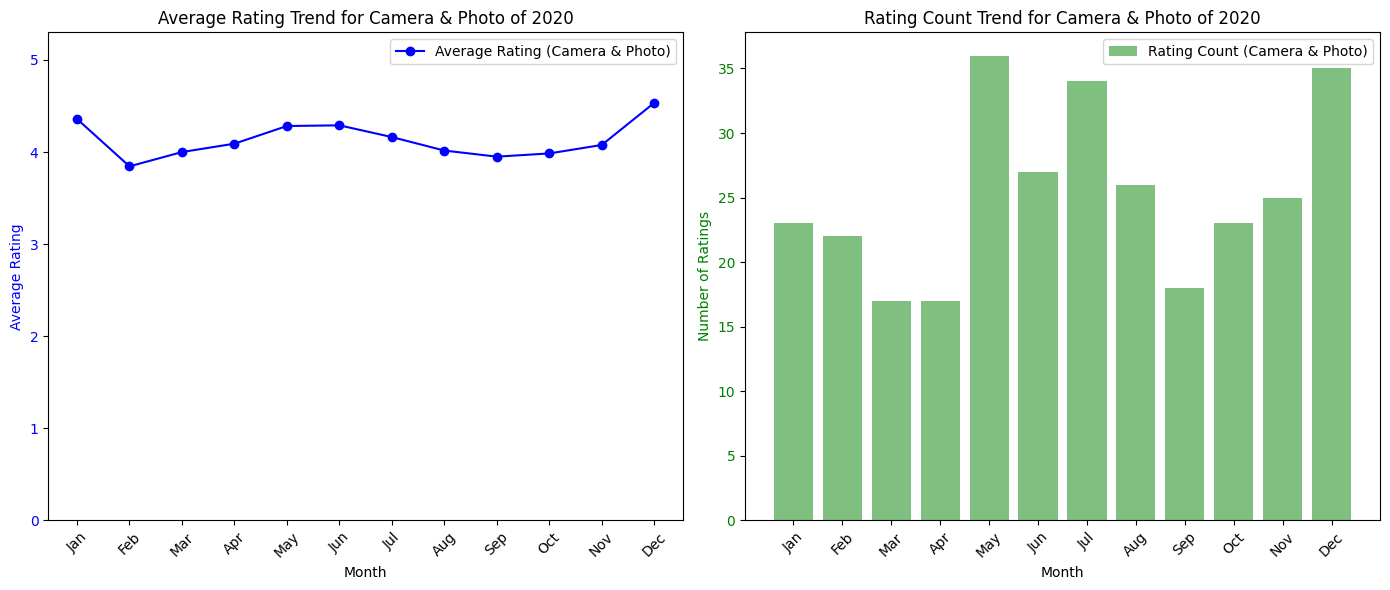

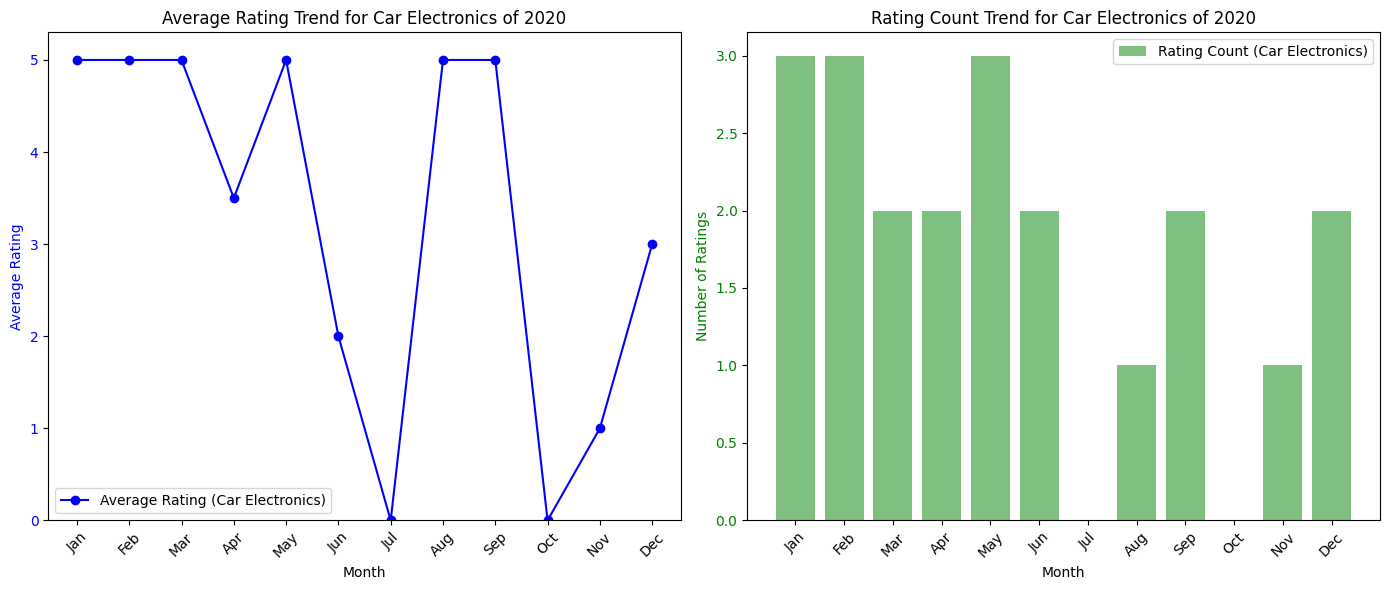

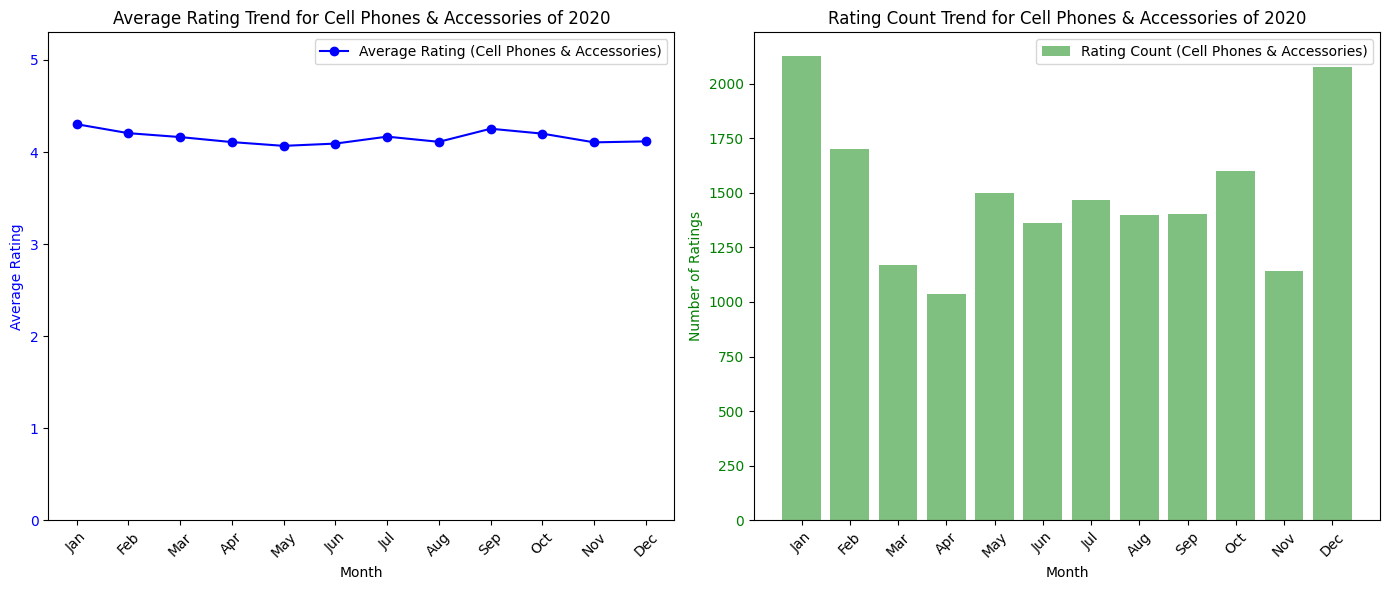

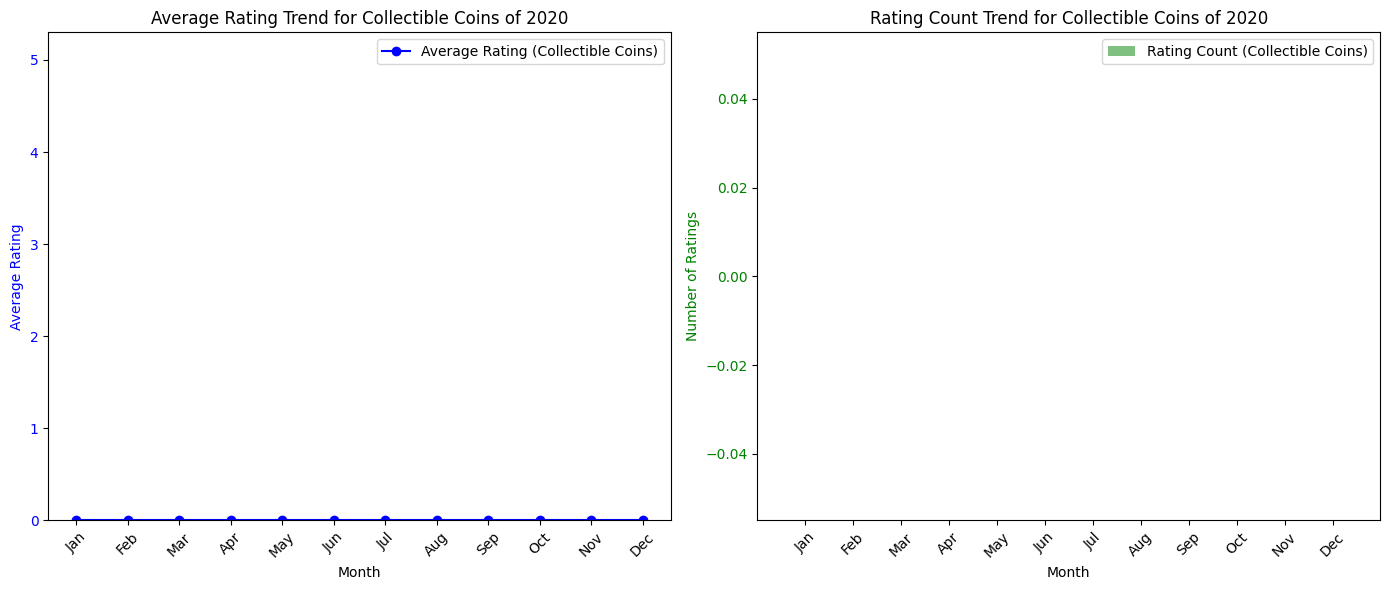

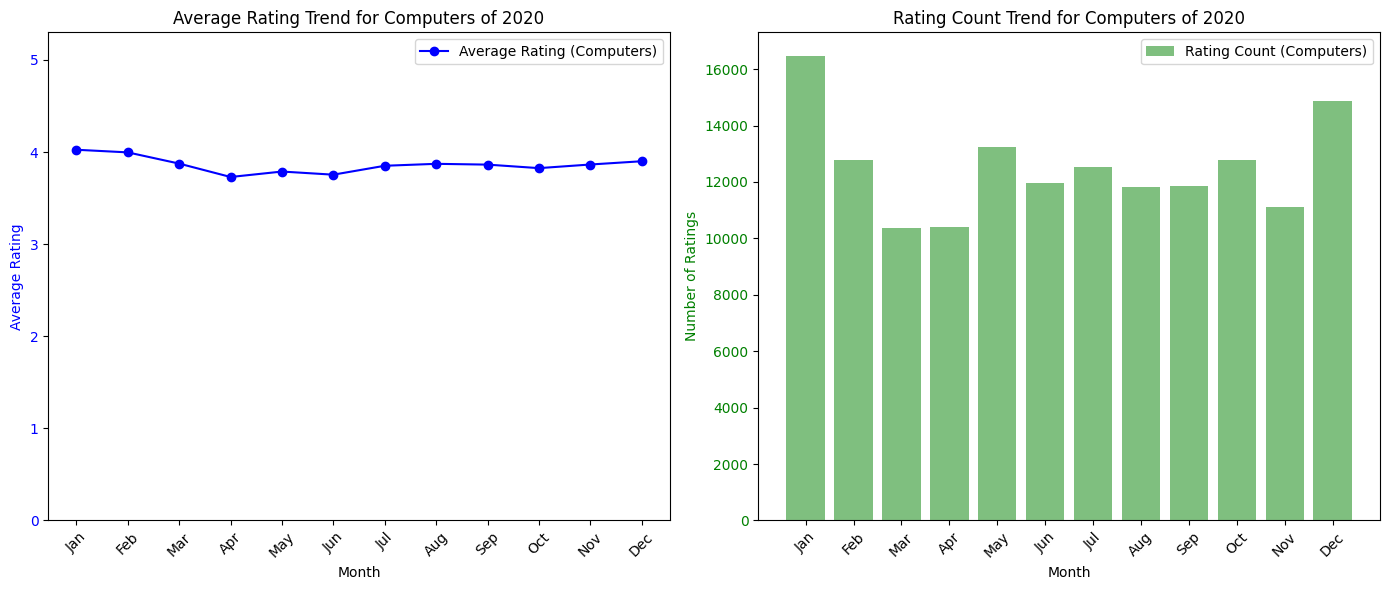

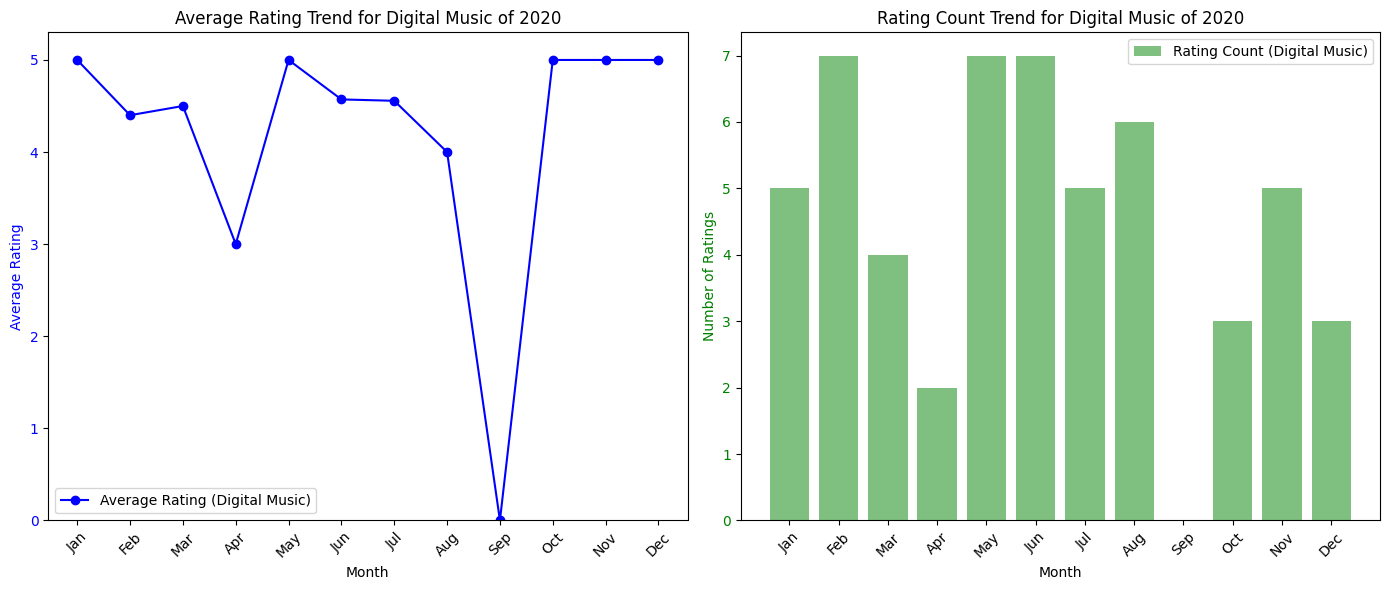

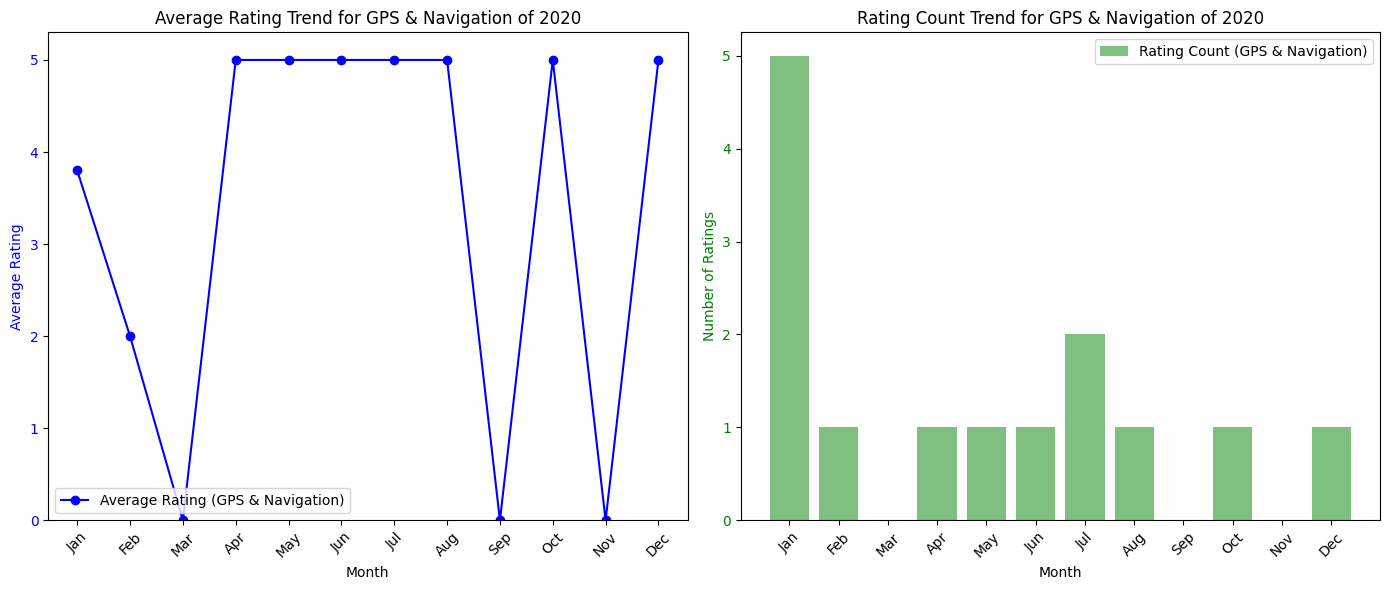

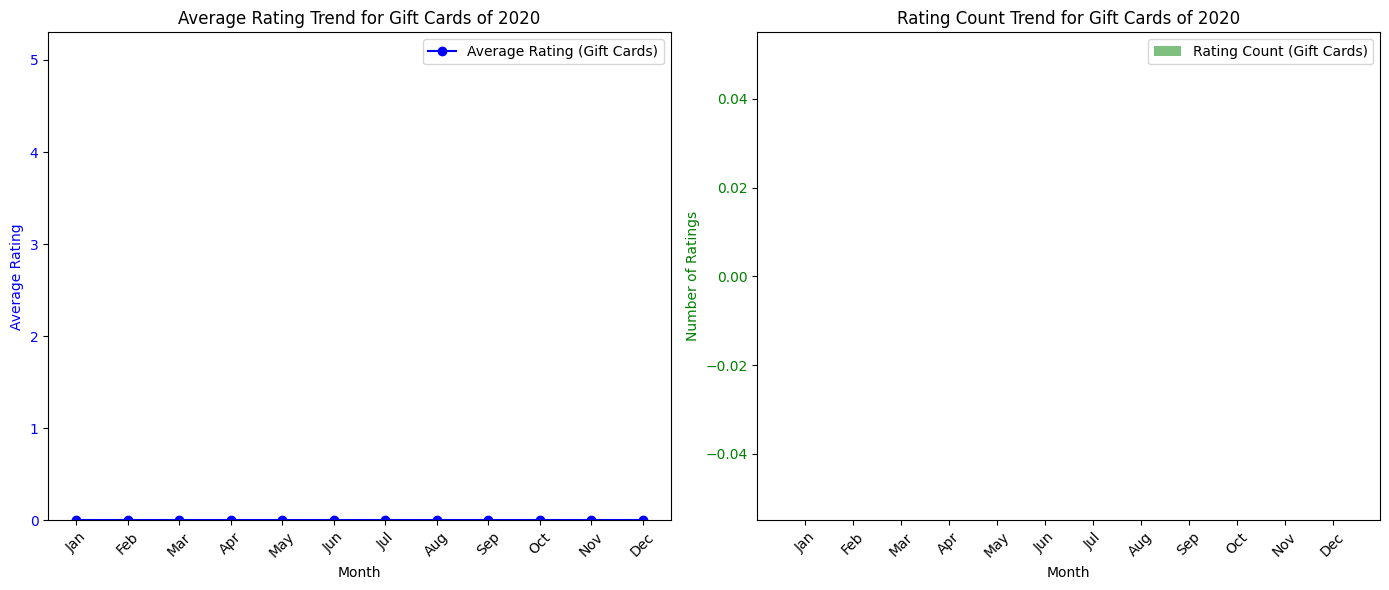

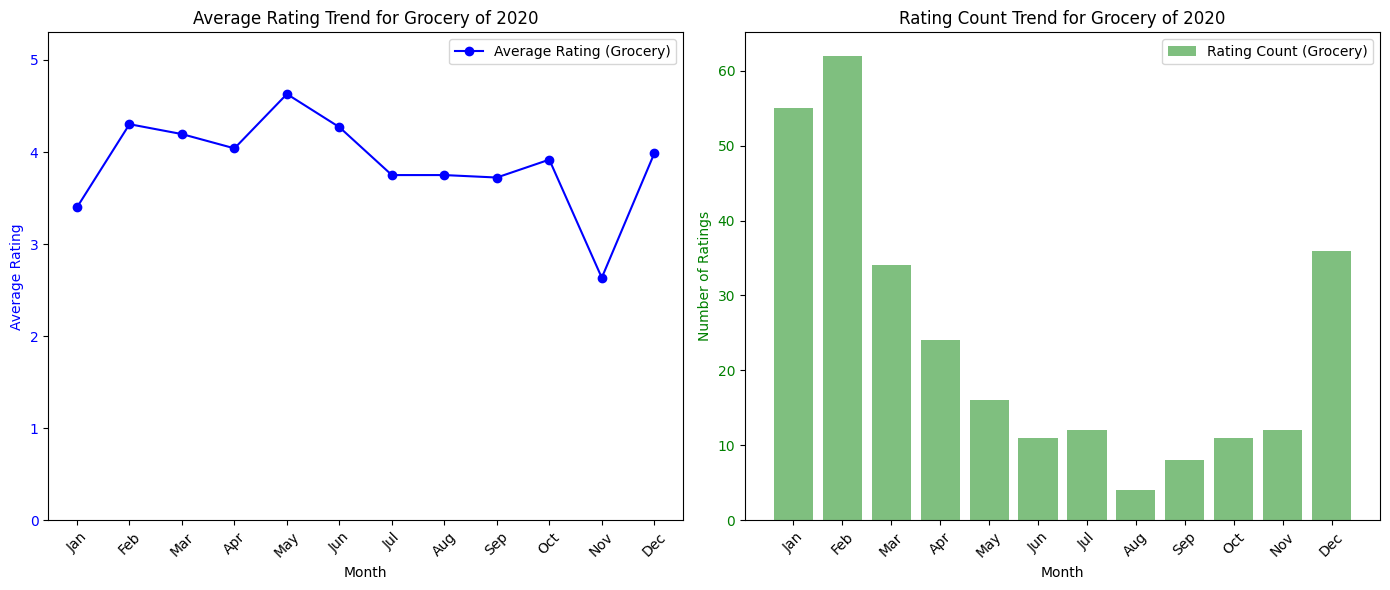

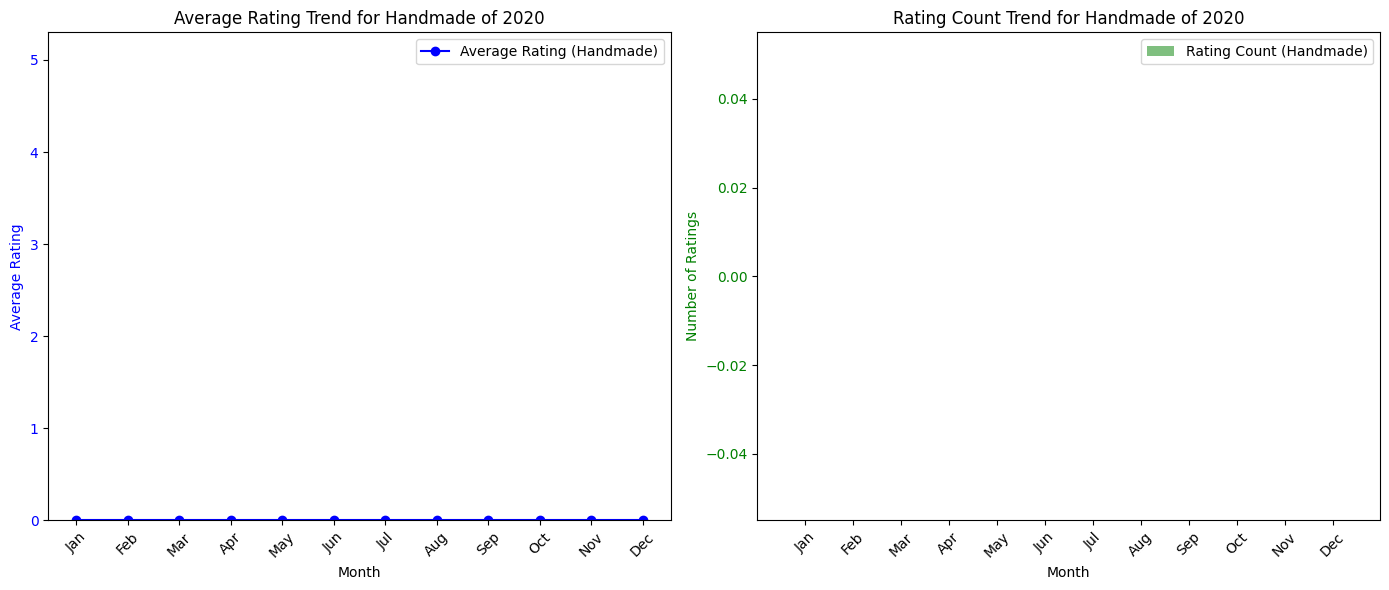

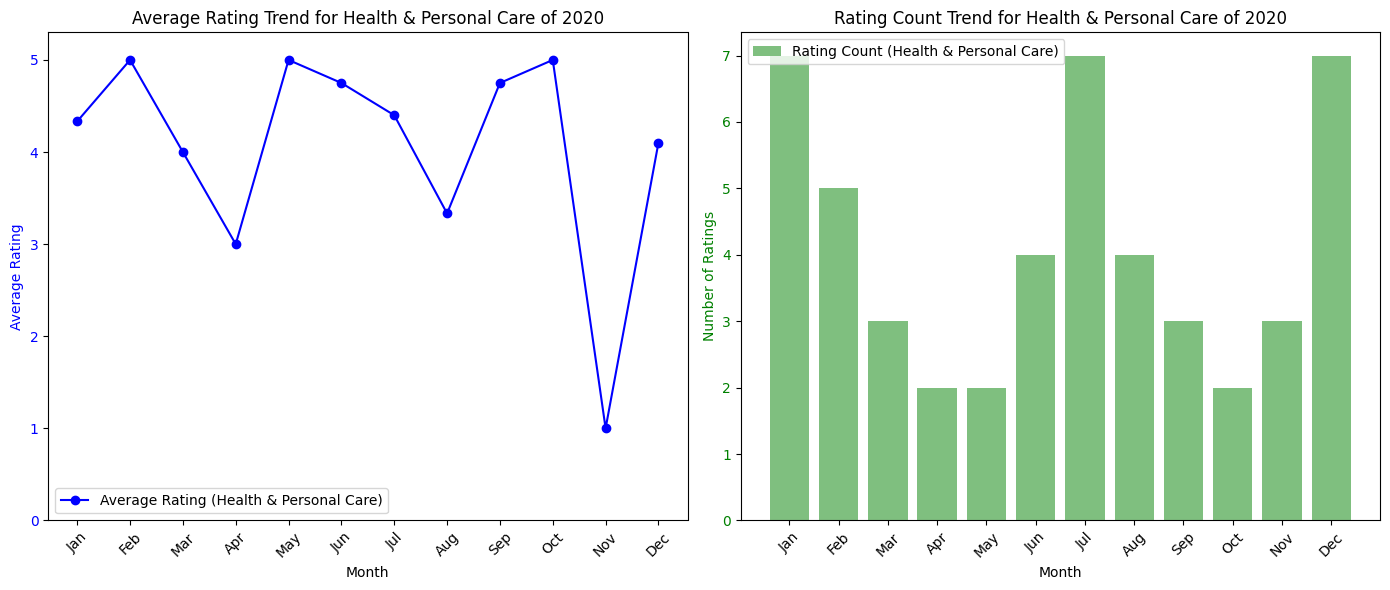

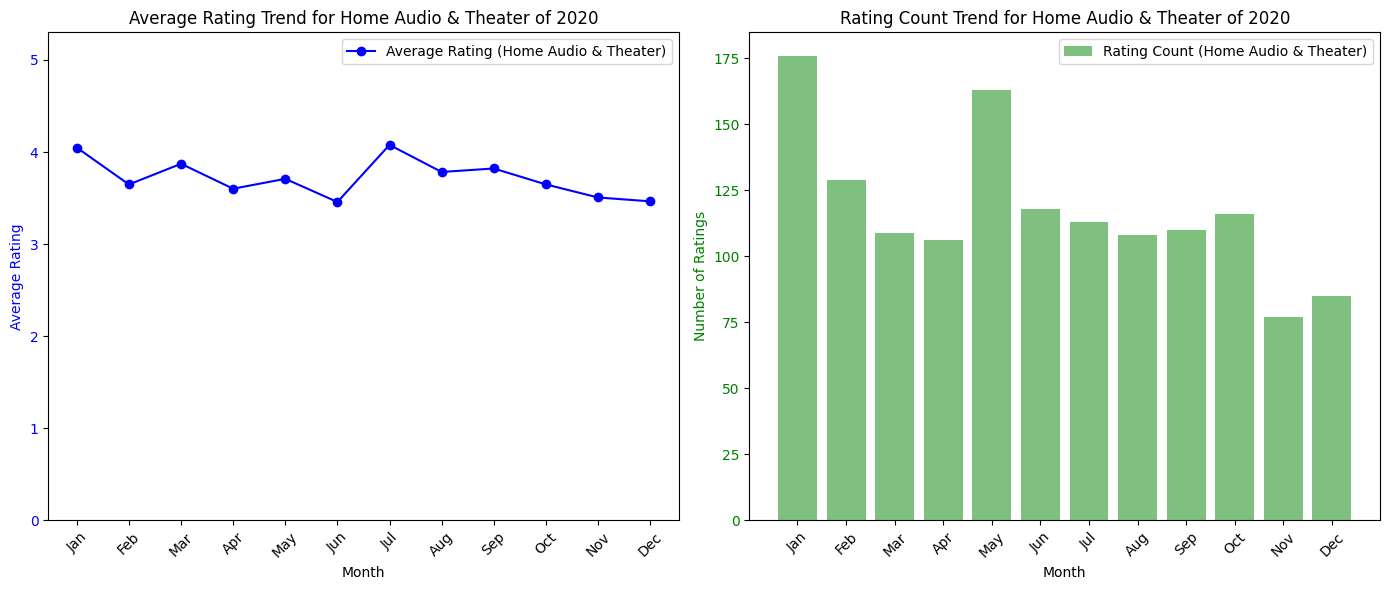

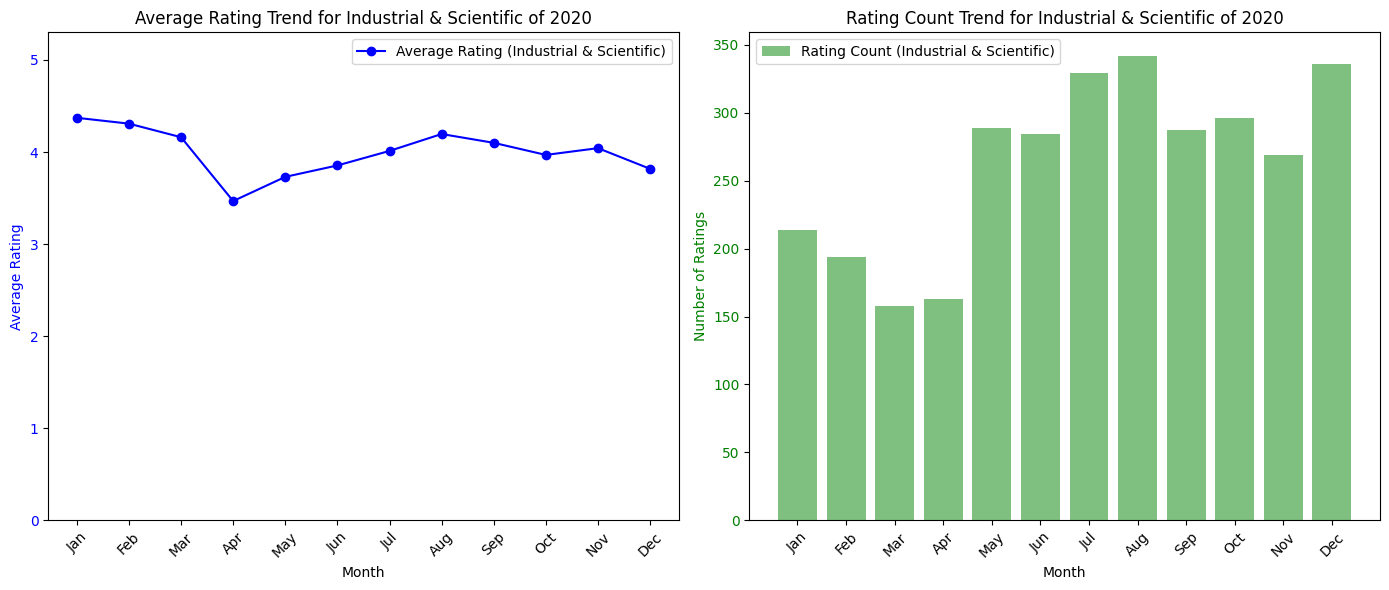

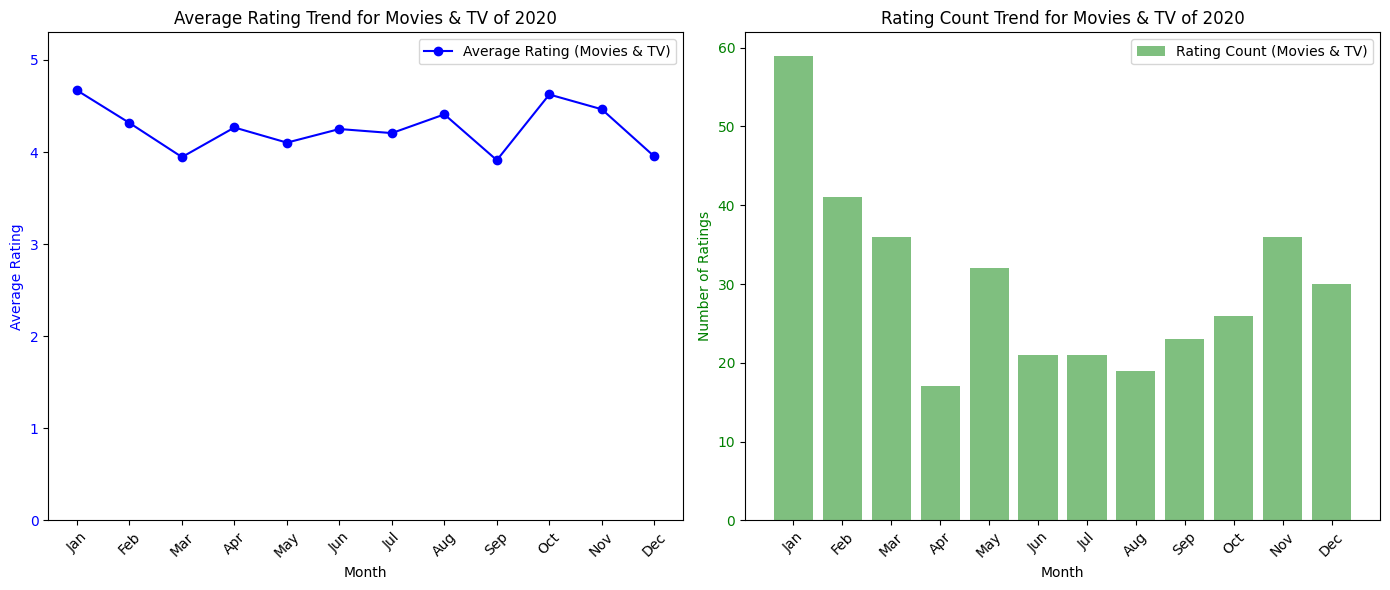

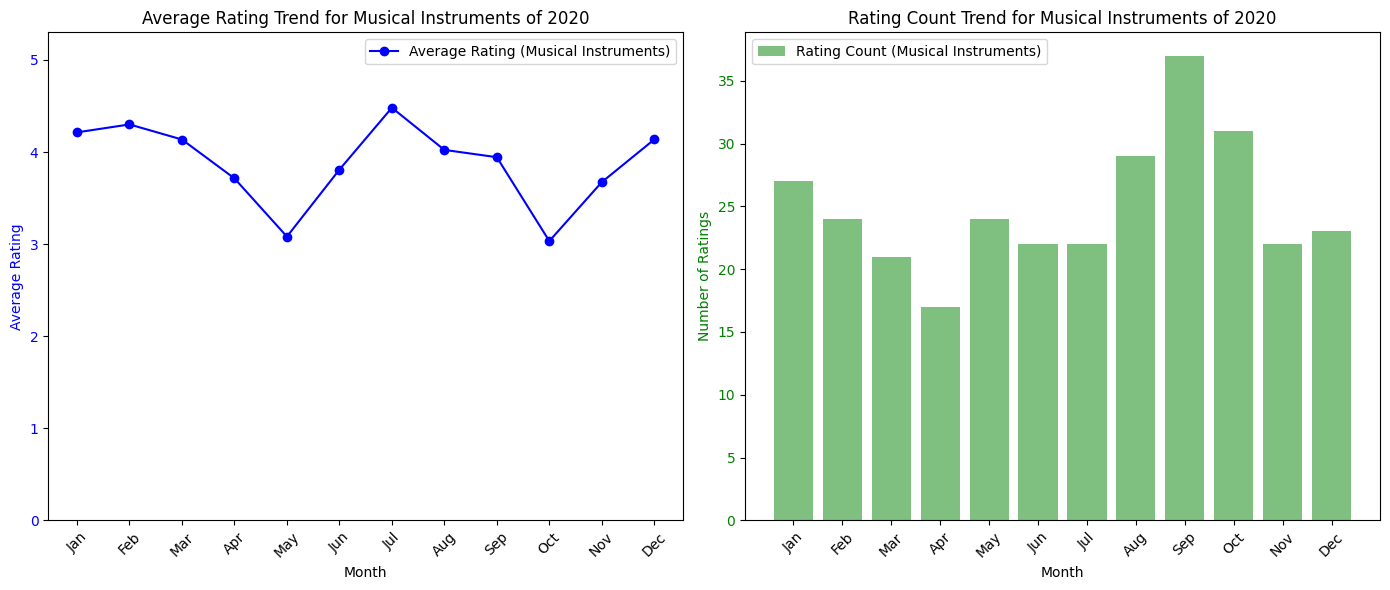

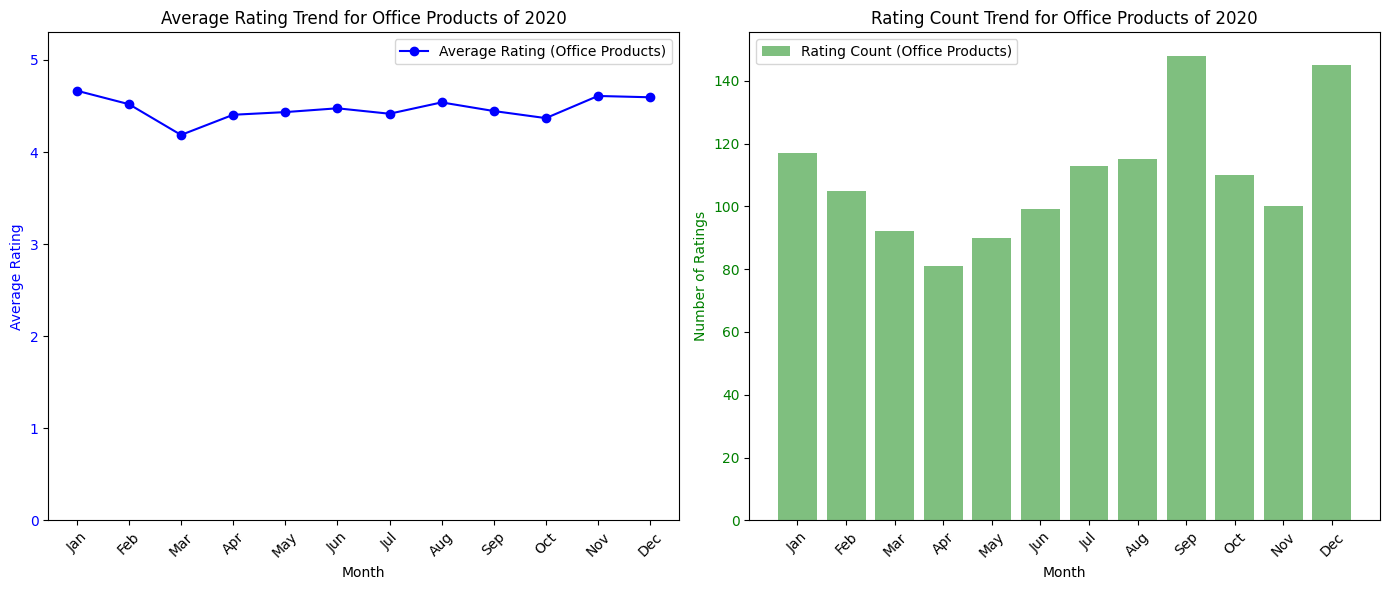

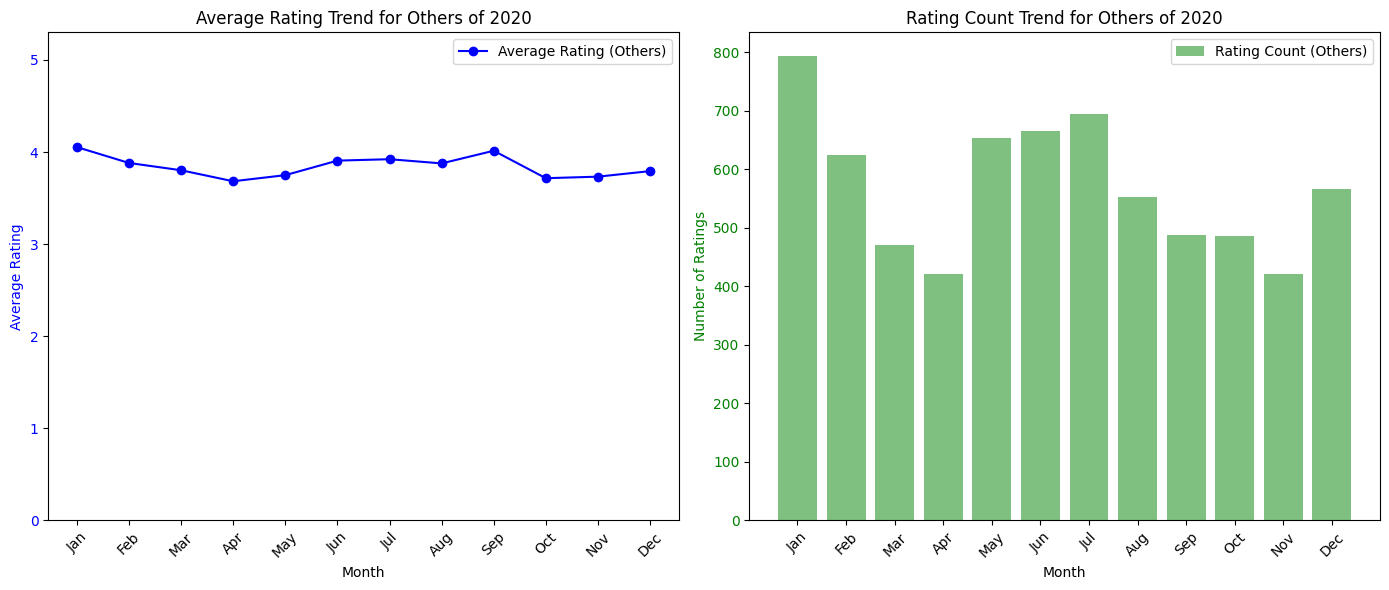

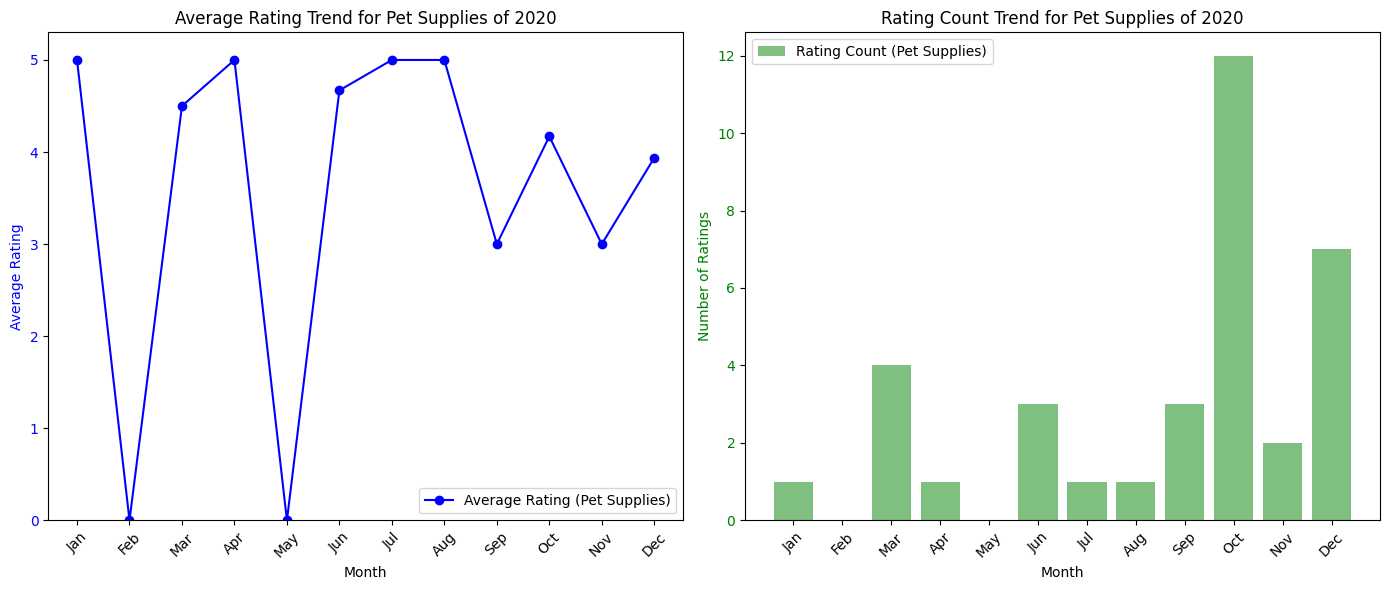

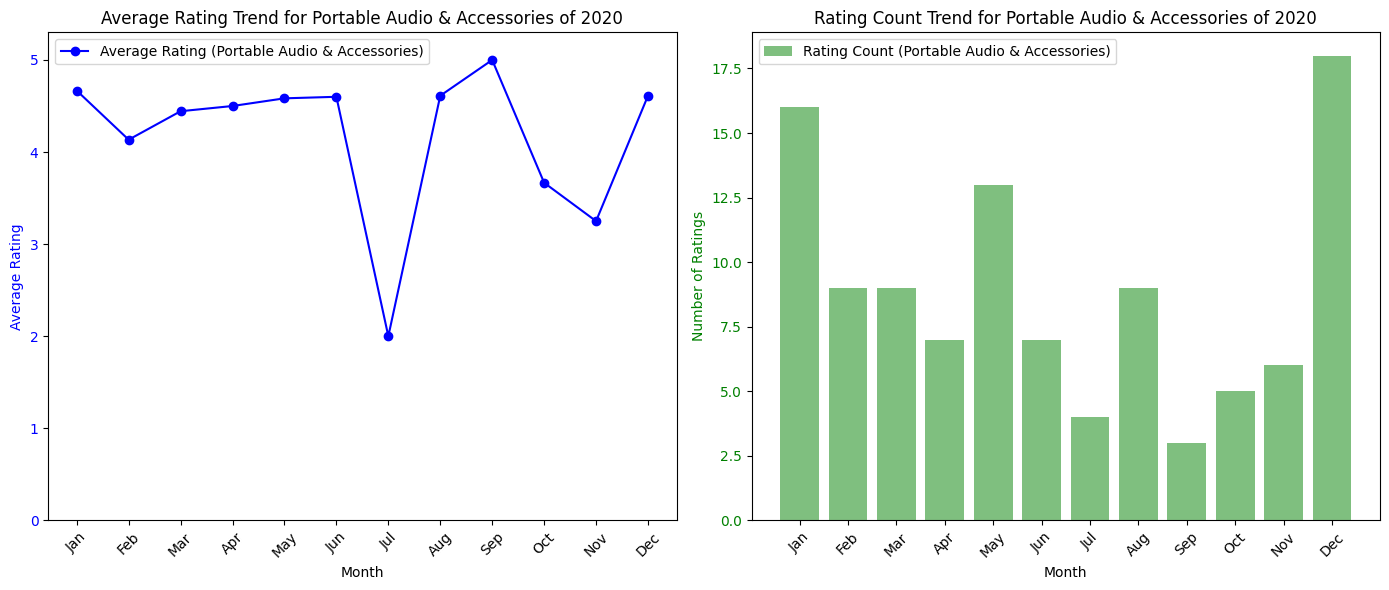

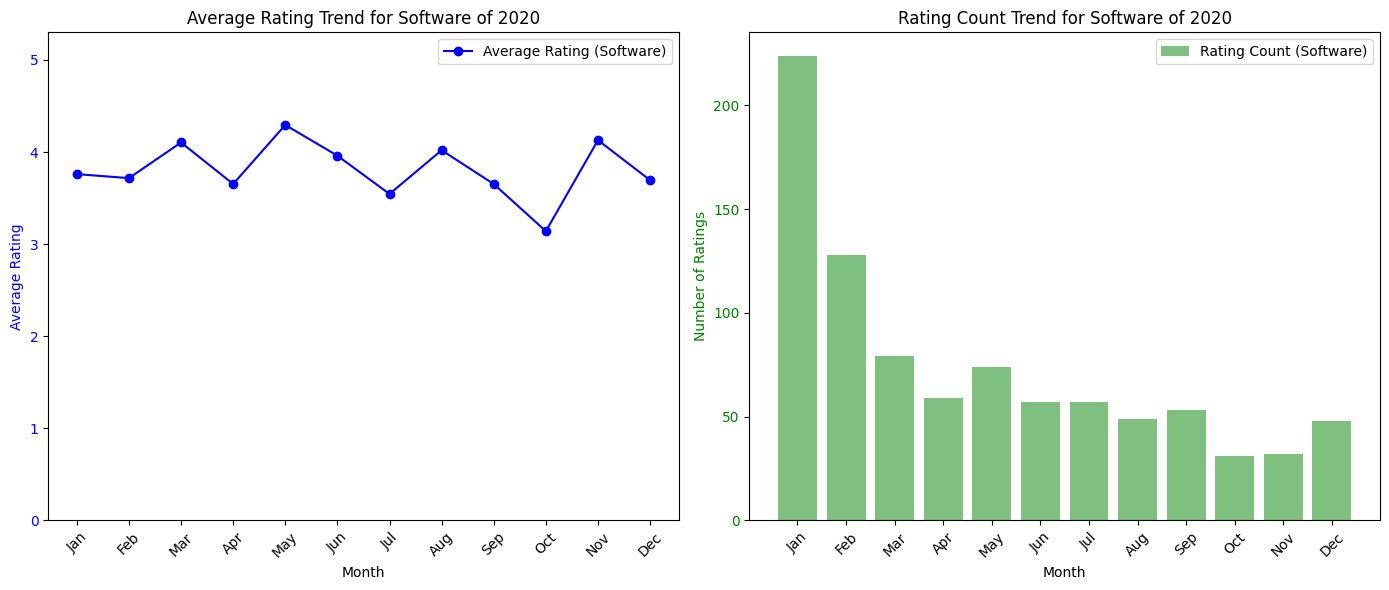

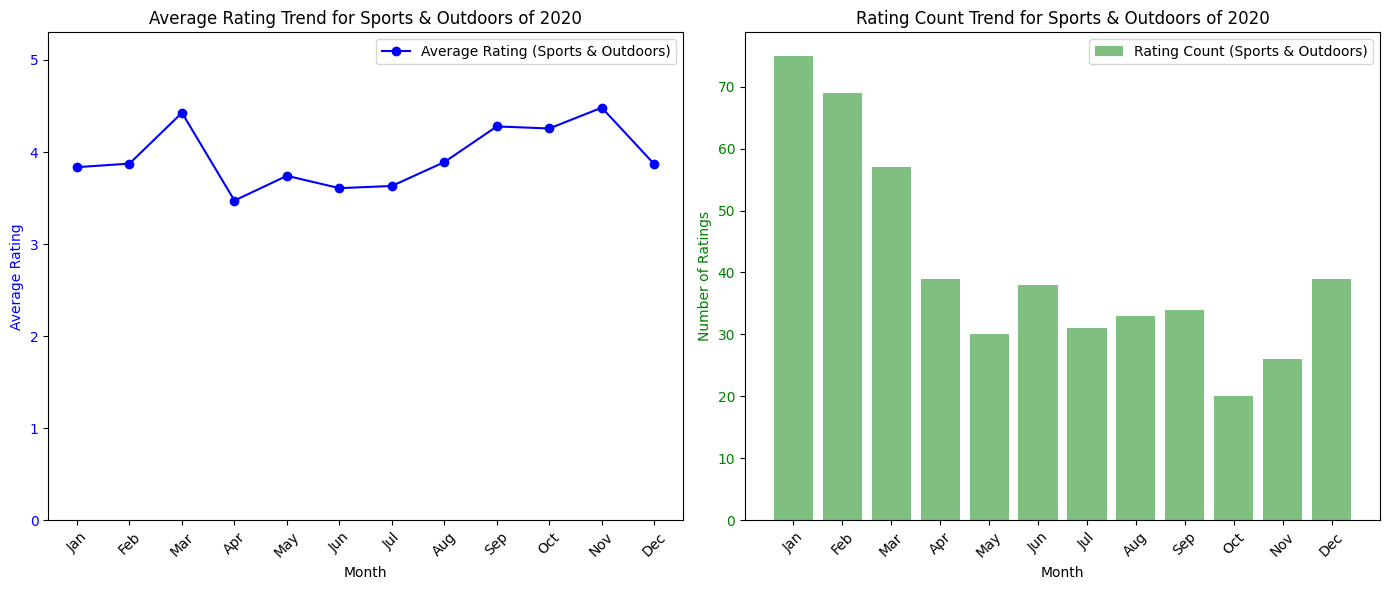

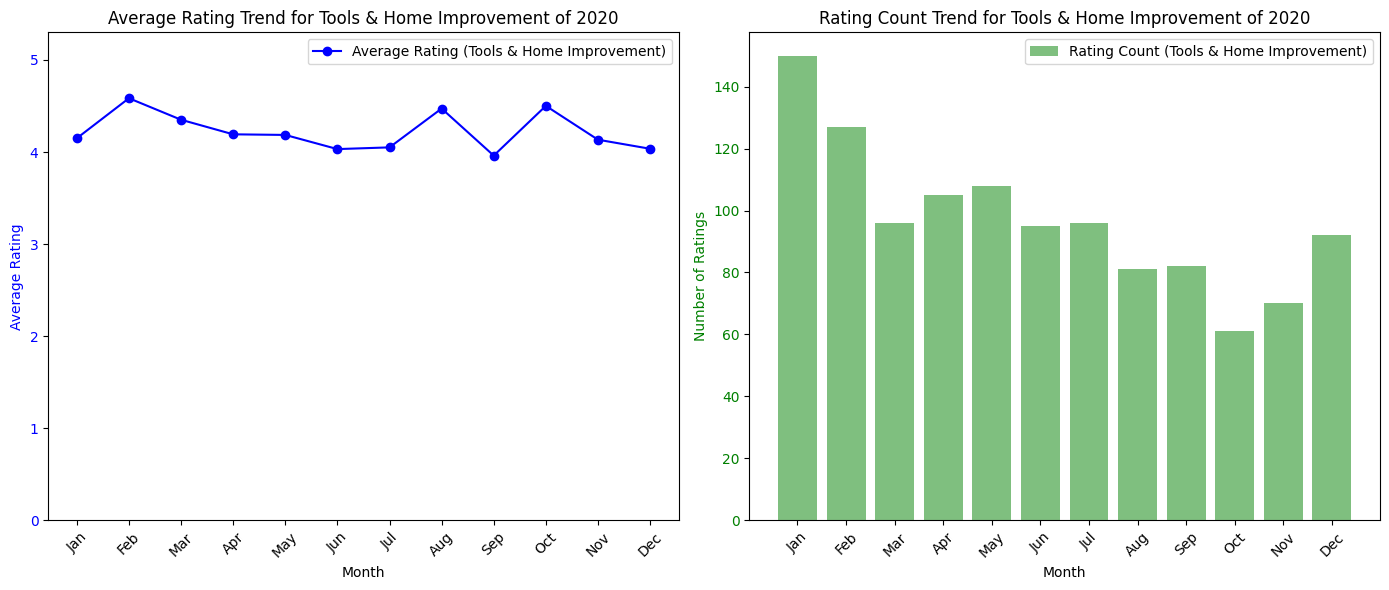

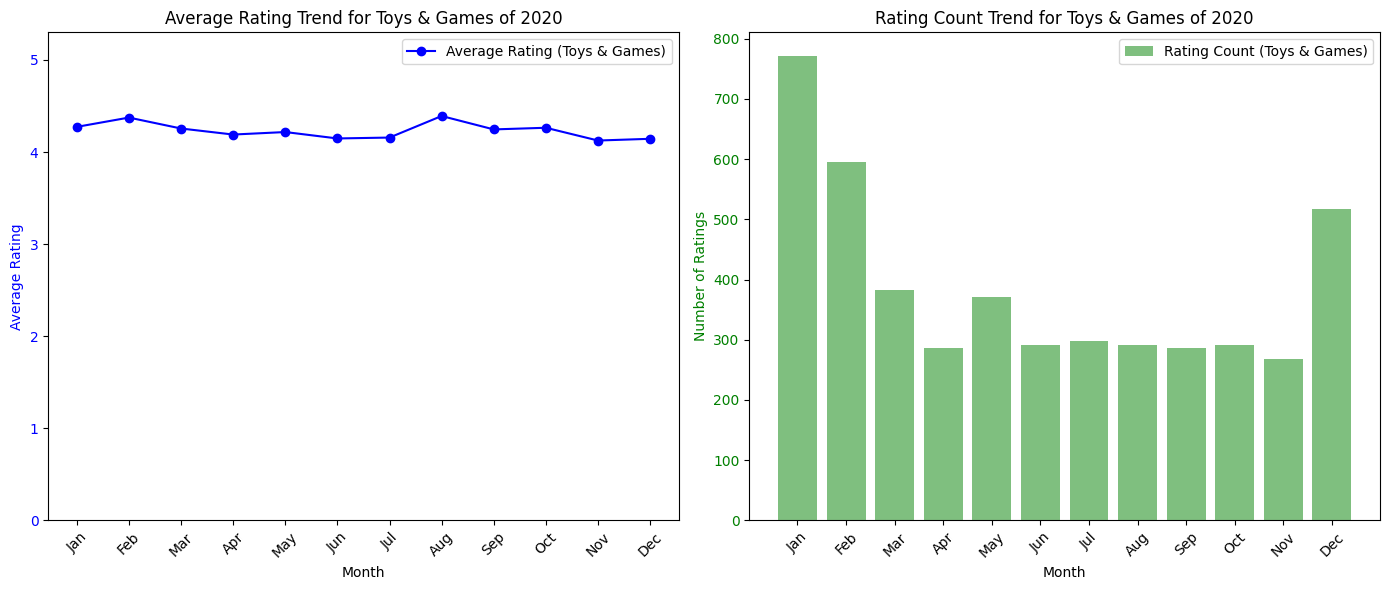

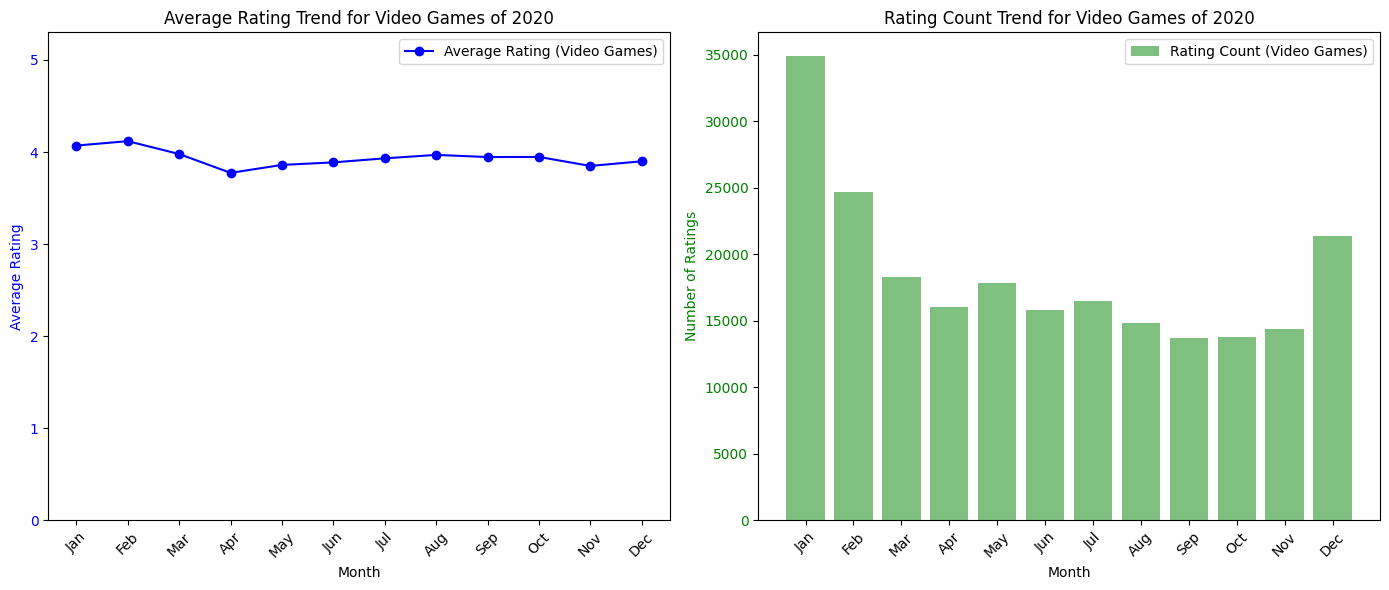

In [134]:
# Set the year to display
year = 2020

# Iterate through each main_category and generate individual plots
for category in unique_categories:
    # Filter the data for the current category and year (2022)
    category_data = agg_df[(agg_df['main_category'] == category) & (agg_df['year'] == year)]
    
    # Create a DataFrame with all months
    all_months_df = pd.DataFrame({
        'month': month_names
    })
    
    # Merge the actual data with the all_months_df, ensuring that all months are represented
    category_data_merged = pd.merge(all_months_df, category_data, on='month', how='left', suffixes=('', '_actual'))
    
    # Fill missing values (NaN) with 0 without modifying the original DataFrame
    category_data_merged['average_rating'] = category_data_merged['average_rating'].fillna(0)
    category_data_merged['rating_count'] = category_data_merged['rating_count'].fillna(0)

    # print(category_data_merged)

    # Create a new figure for each category
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Left subplot: Plot average rating (line plot)
    ax1 = axes[0]
    ax1.plot(category_data_merged['month'], category_data_merged['average_rating'], label=f'Average Rating ({category})', color='b', marker='o')
    ax1.set_title(f'Average Rating Trend for {category} of {year}')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Rating', color='b')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend()
    ax1.set_ylim(0, 5.3)  # Set y-axis limits to 0-5 for all graphs

    # Right subplot: Plot rating count (bar plot)
    ax2 = axes[1]
    ax2.bar(category_data_merged['month'], category_data_merged['rating_count'], label=f'Rating Count ({category})', alpha=0.5, color='g')
    ax2.set_title(f'Rating Count Trend for {category} of {year}')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Number of Ratings', color='g')
    ax2.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.legend()

    # Adjust layout to avoid overlapping subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


## Display Monthly Average Rating and Rating Numbers by Main Category for Multiple Years for Comparison

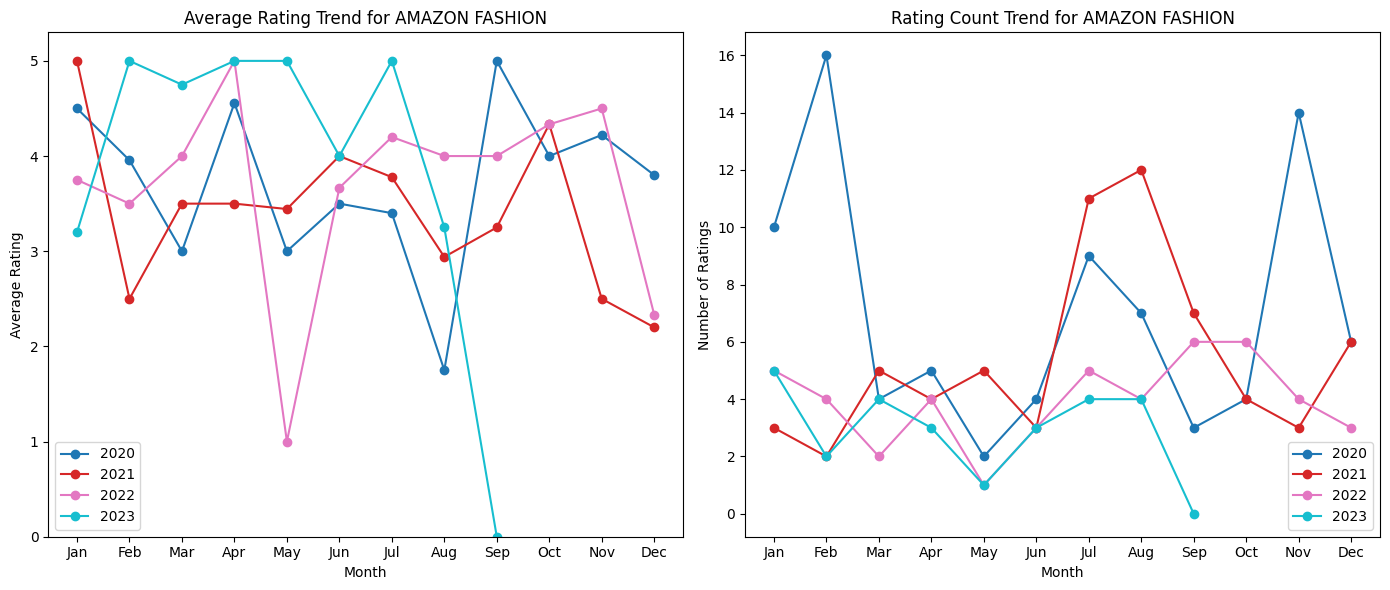

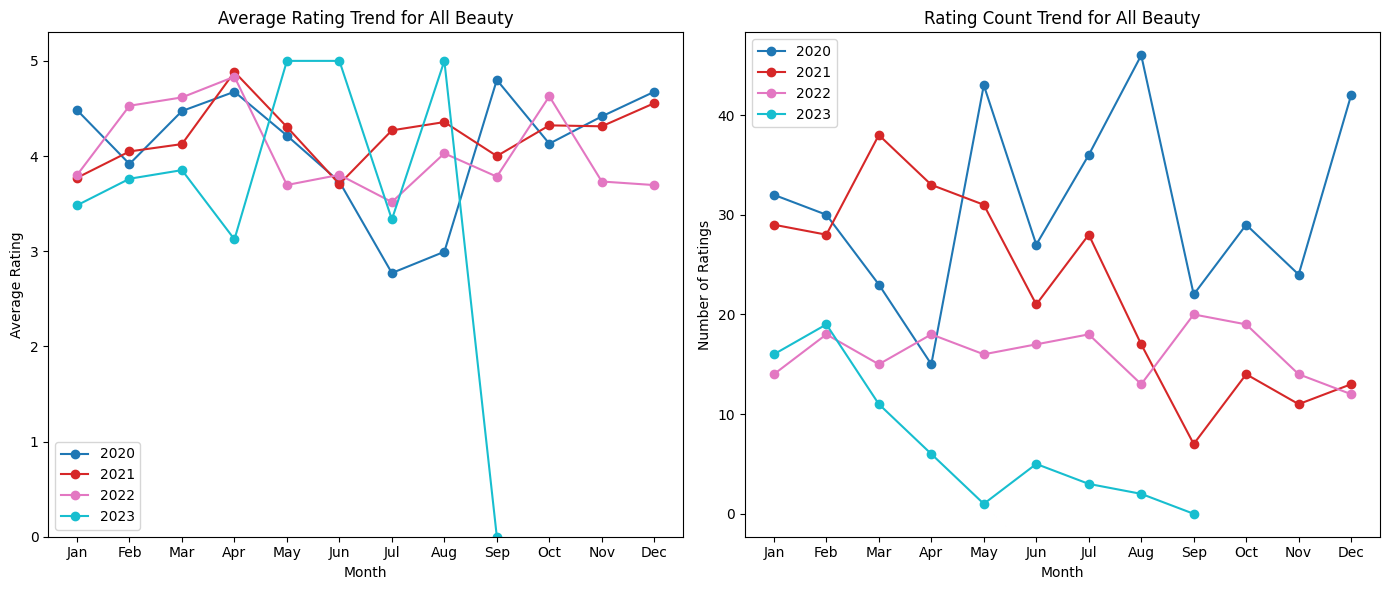

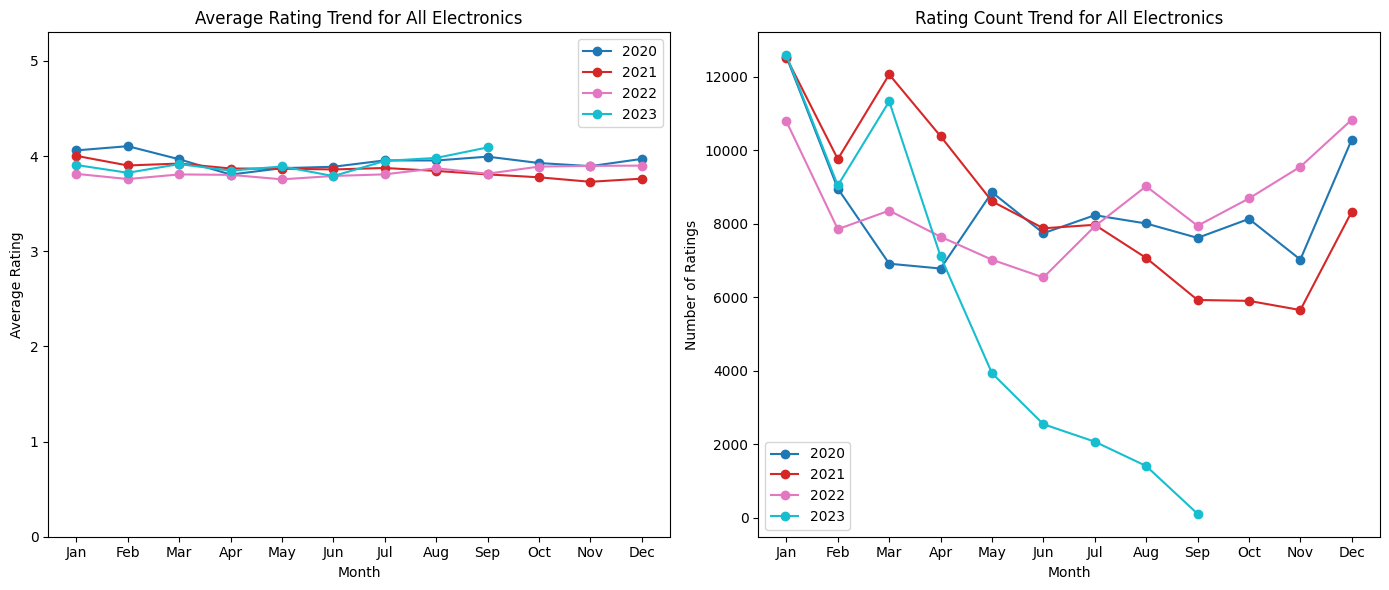

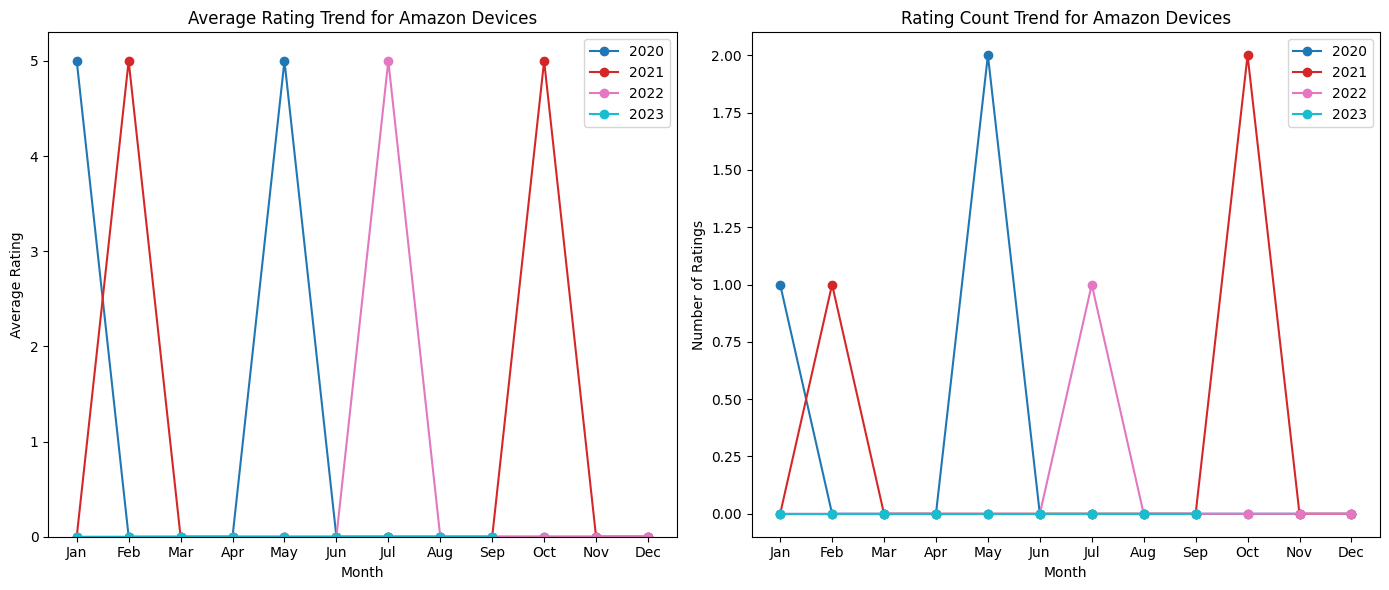

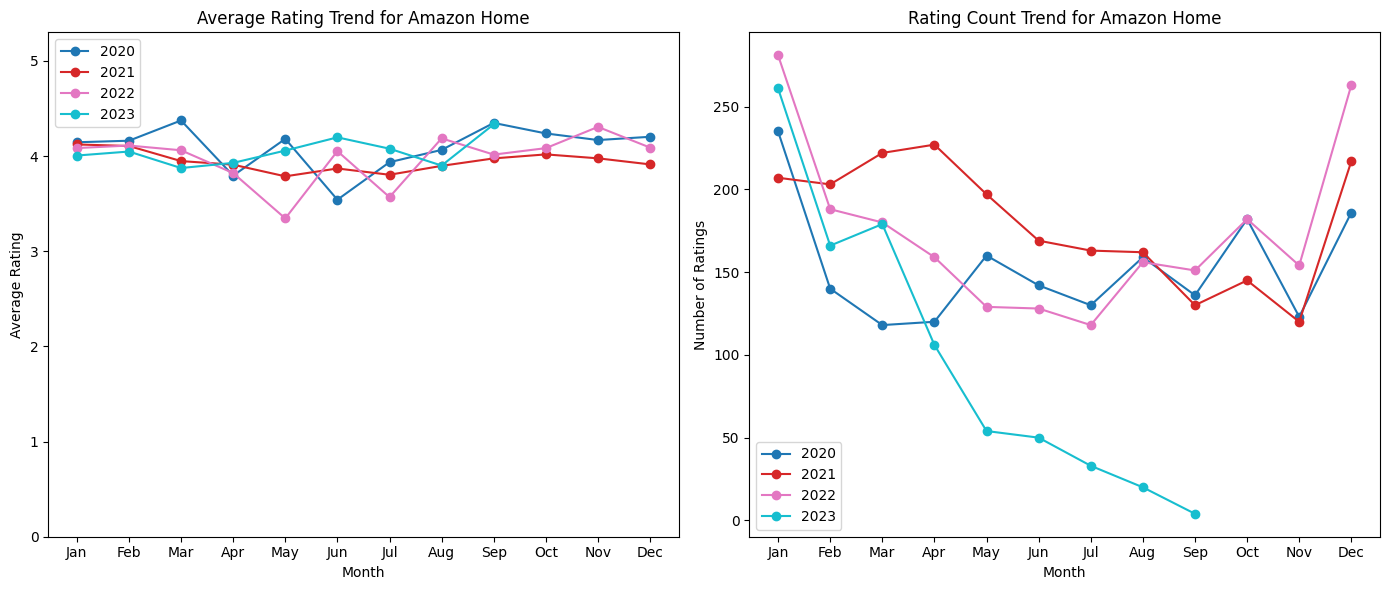

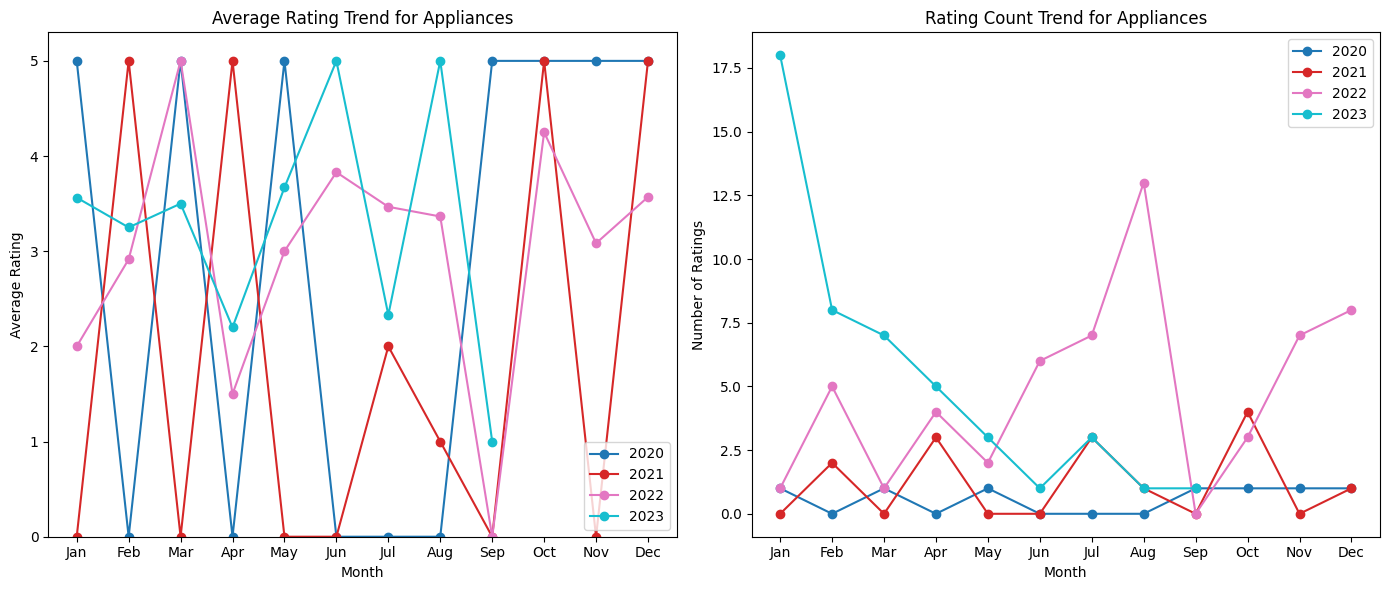

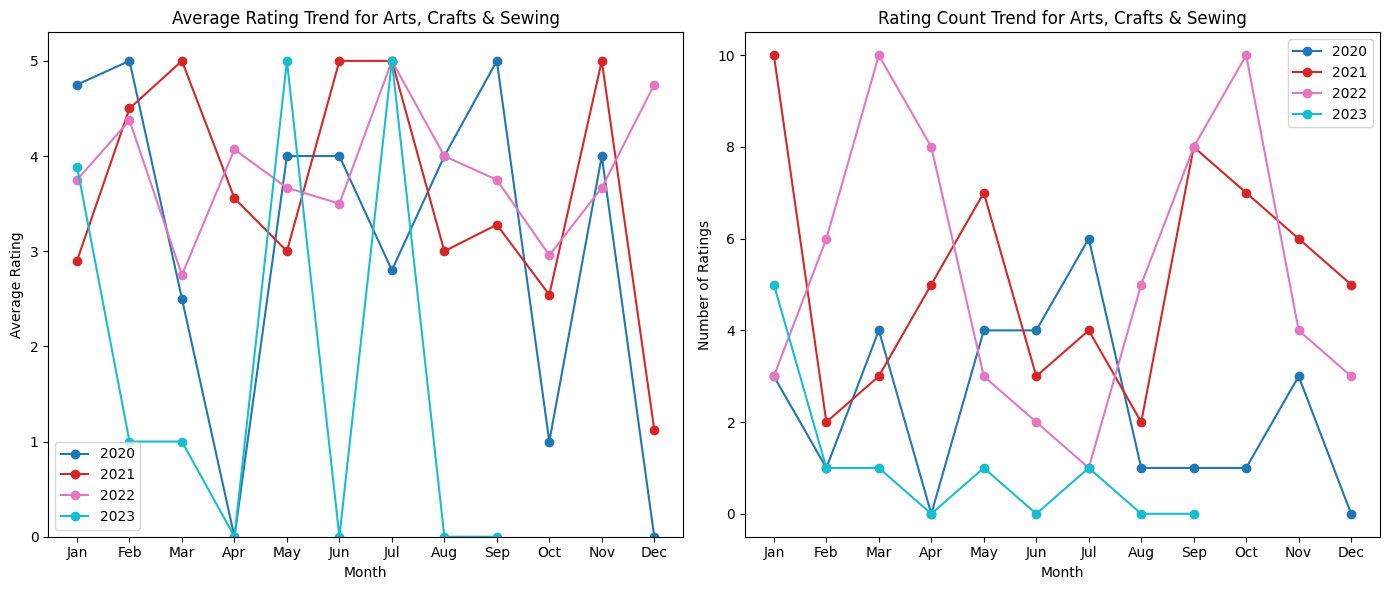

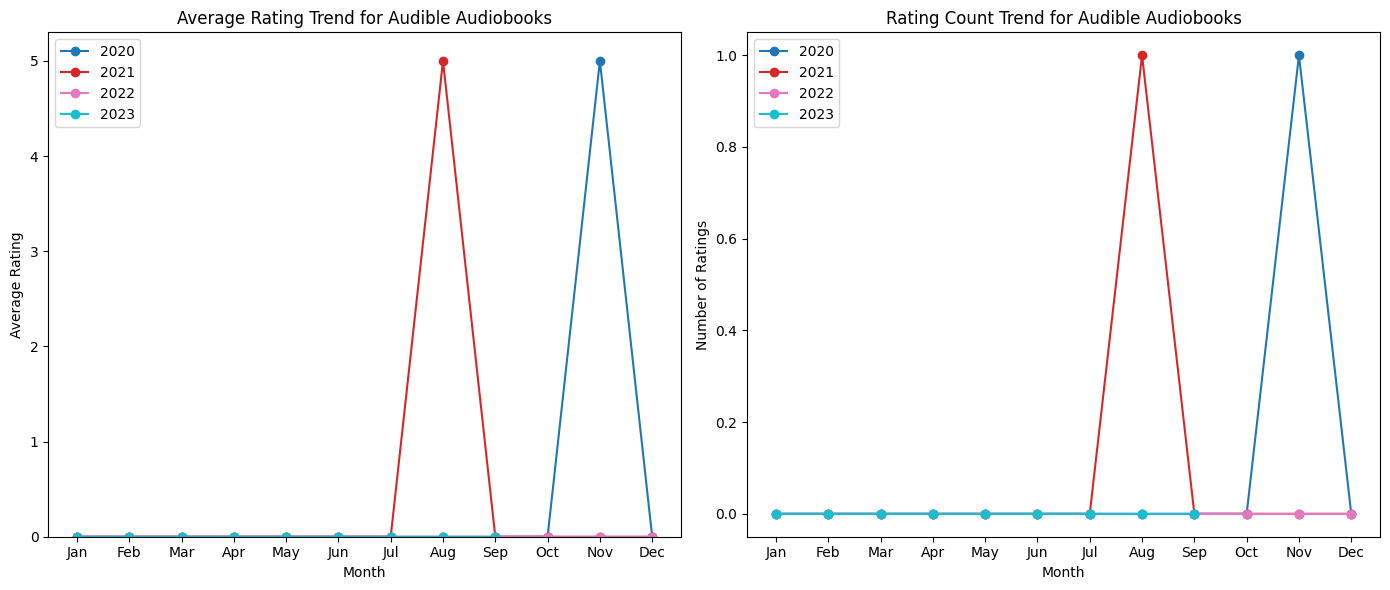

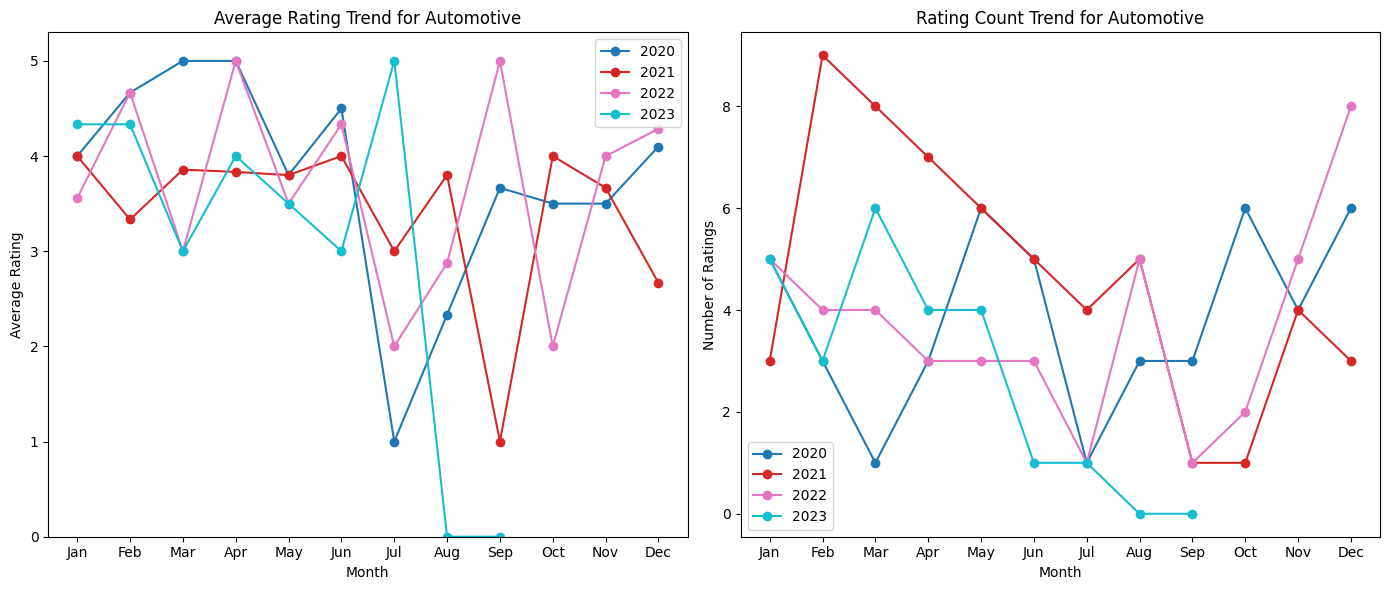

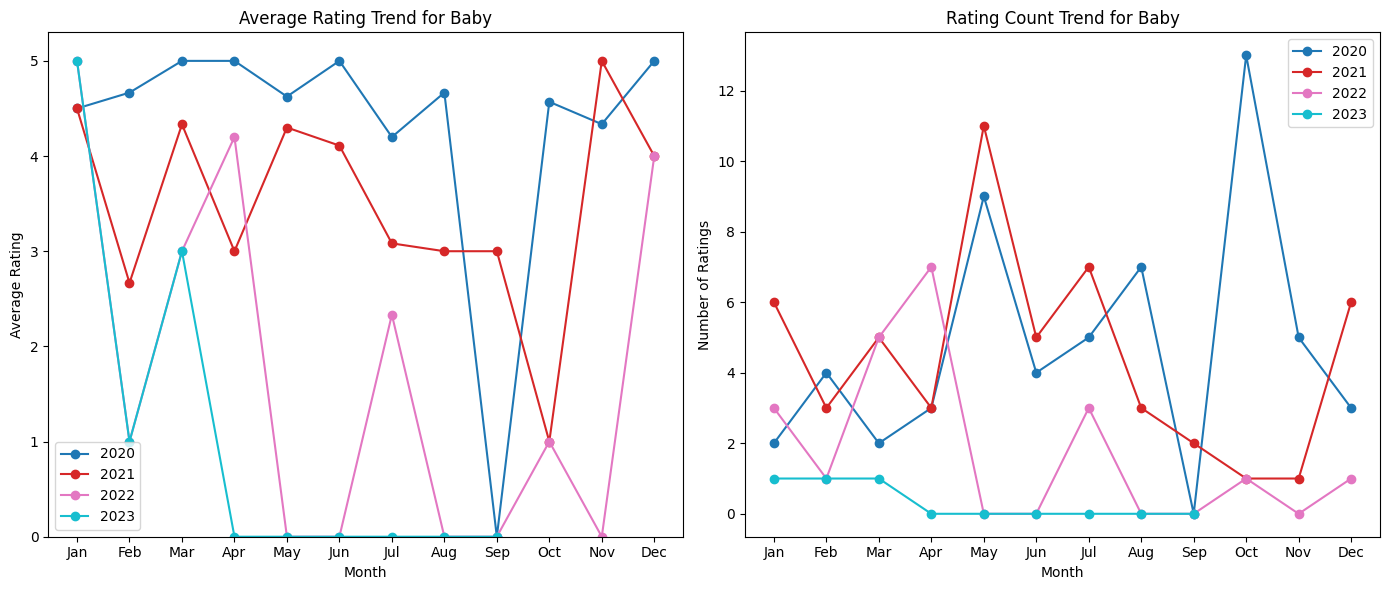

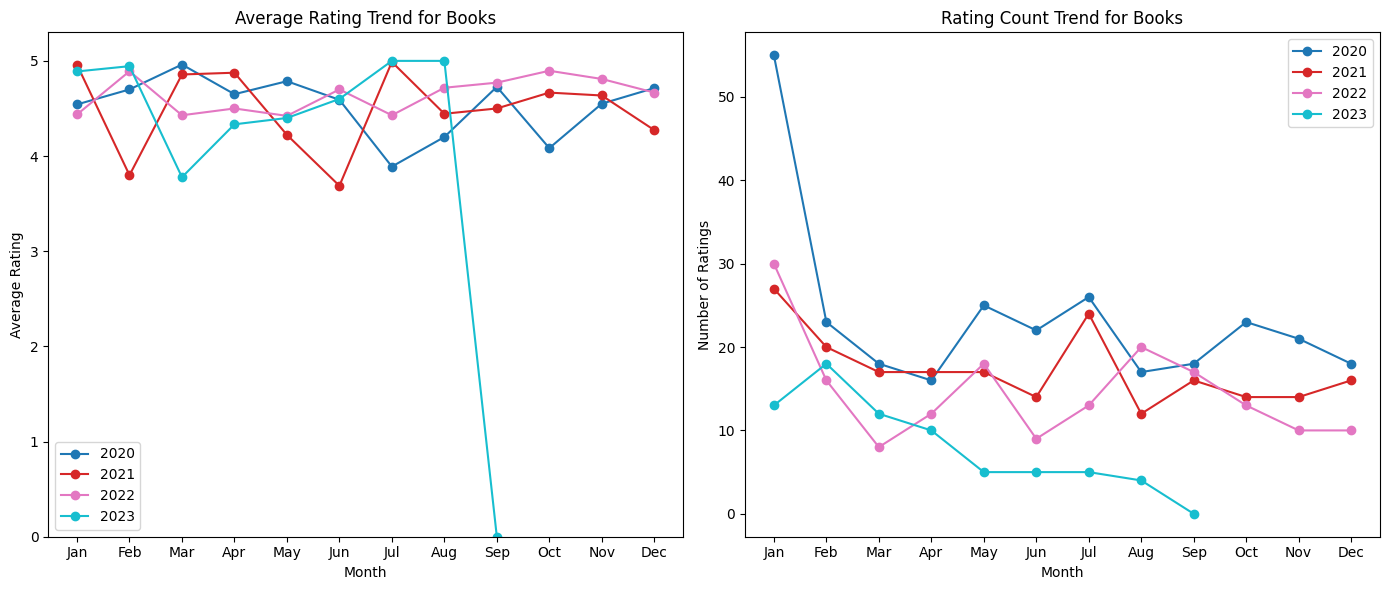

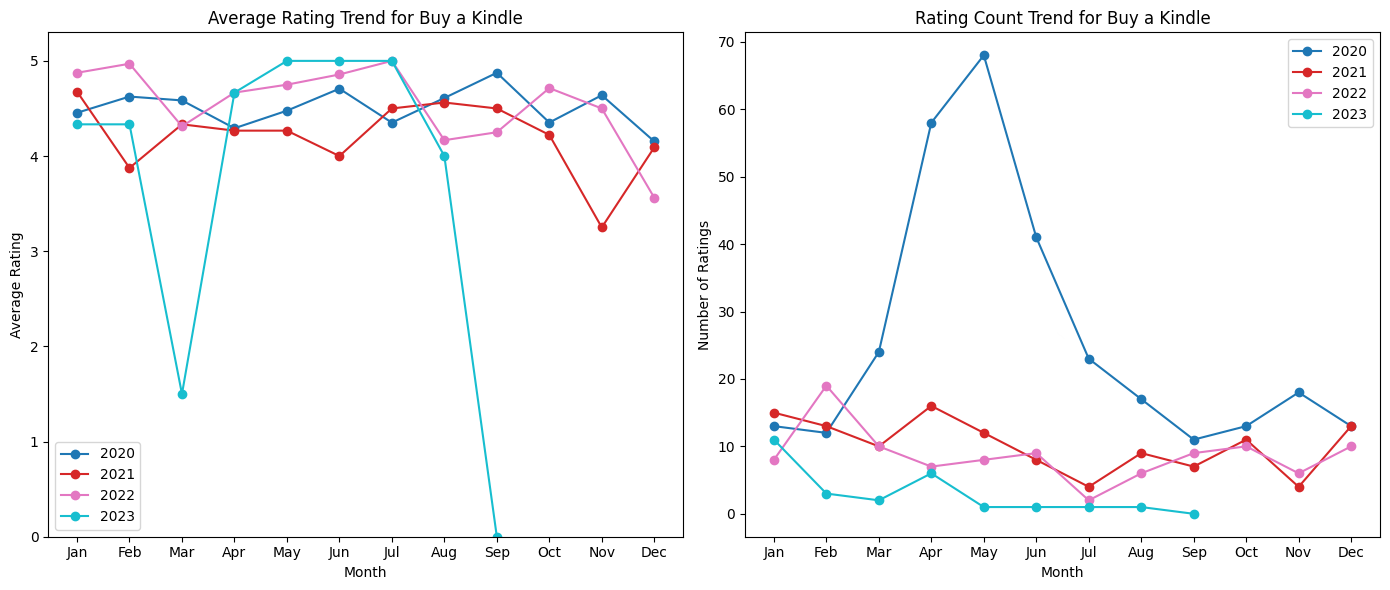

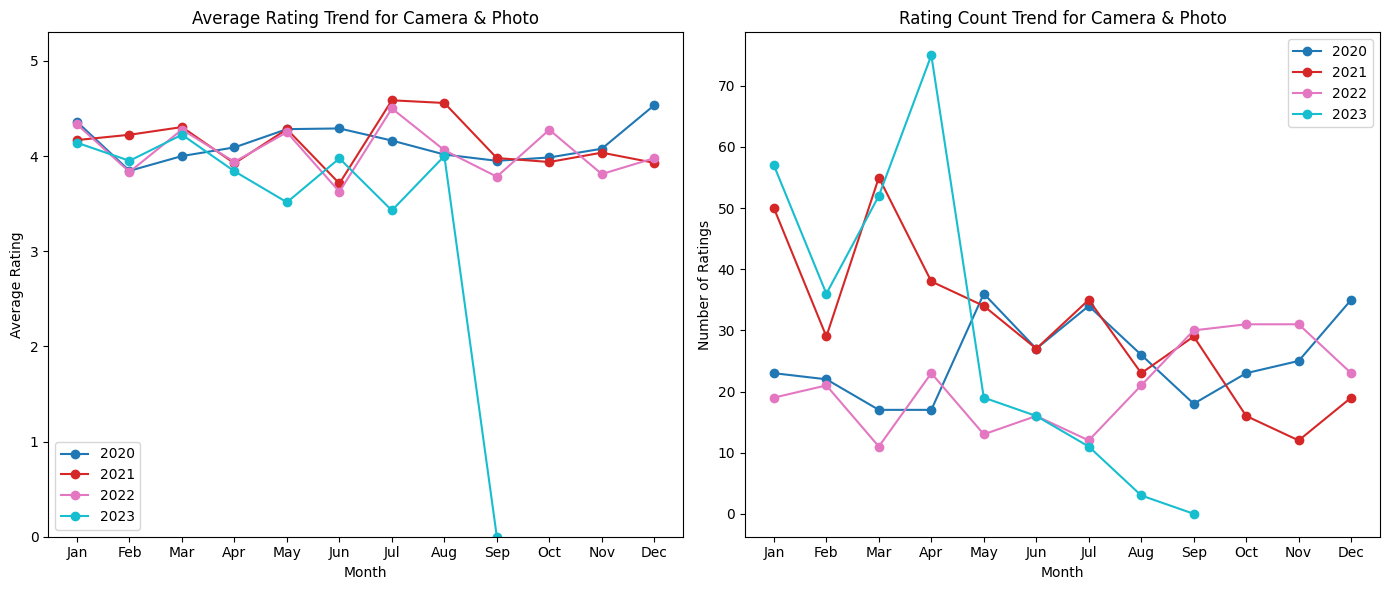

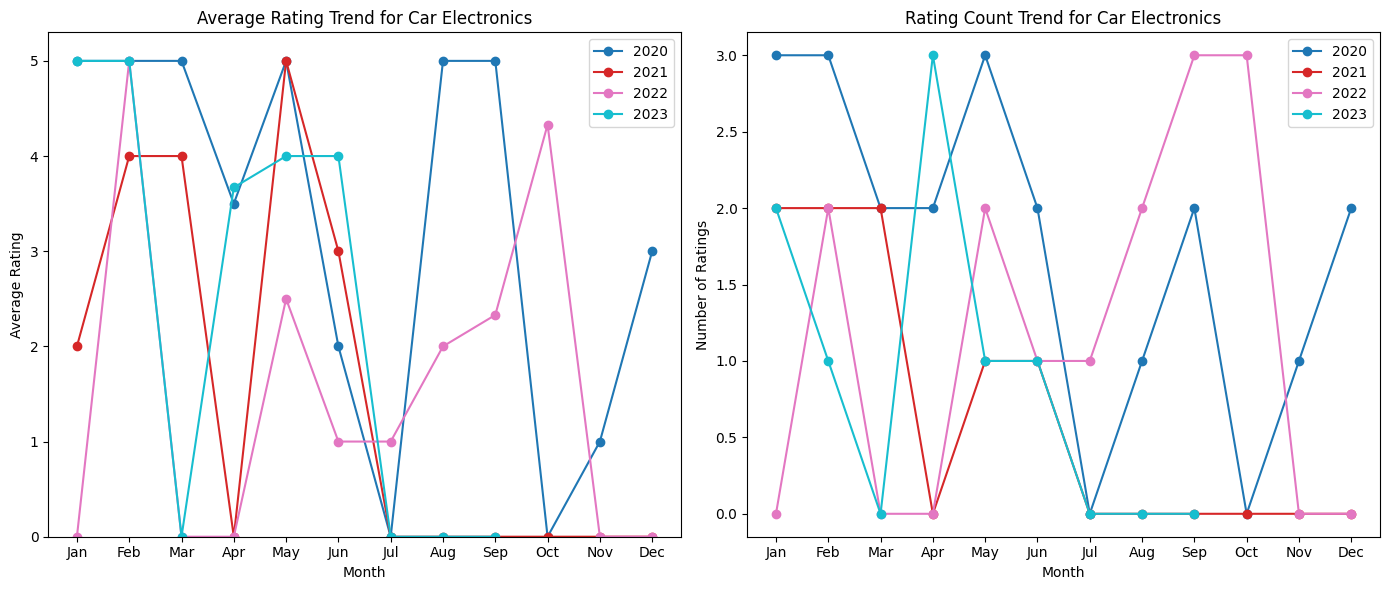

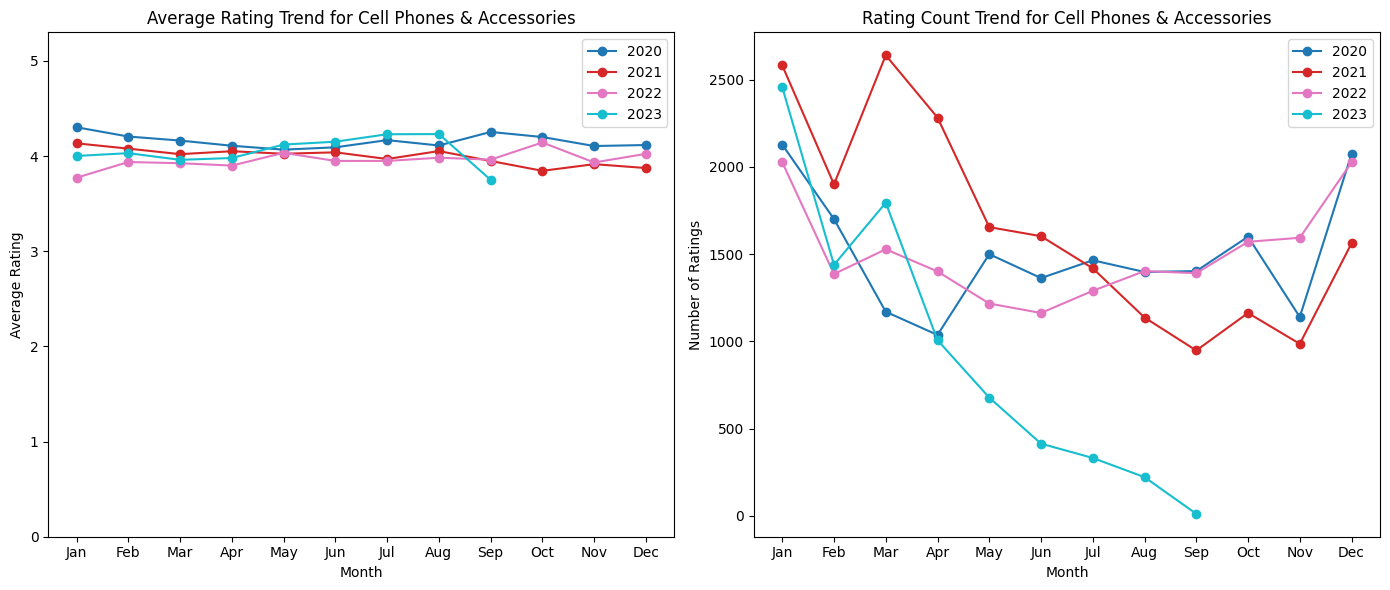

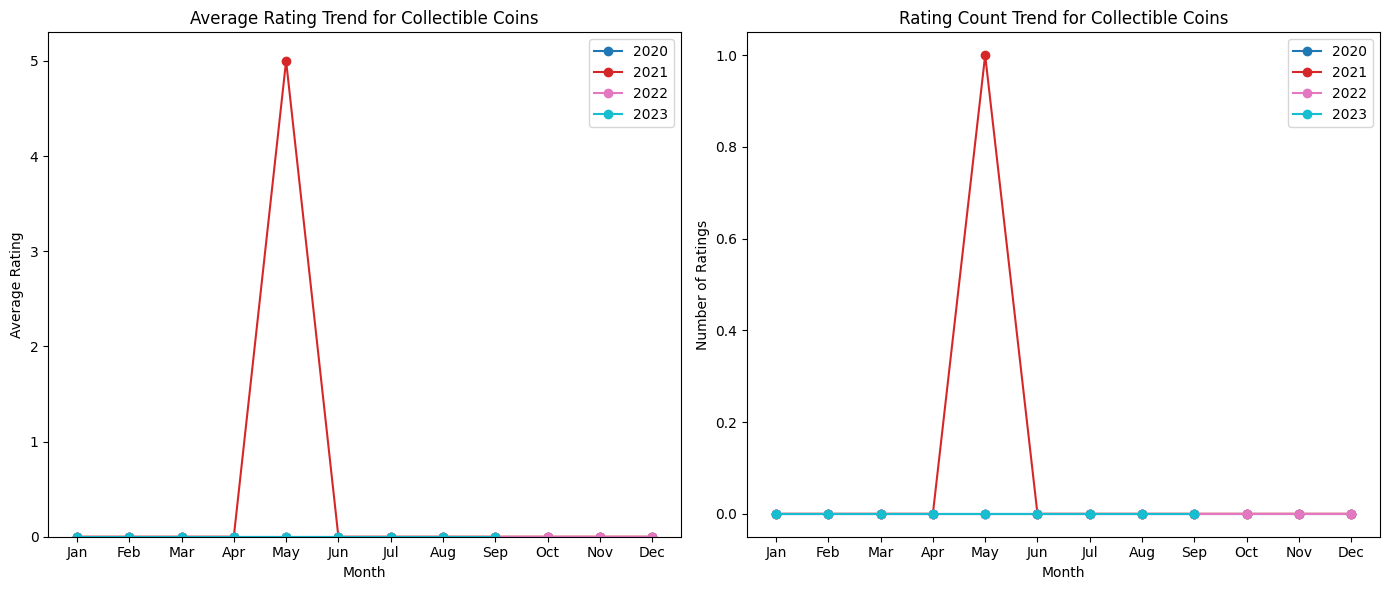

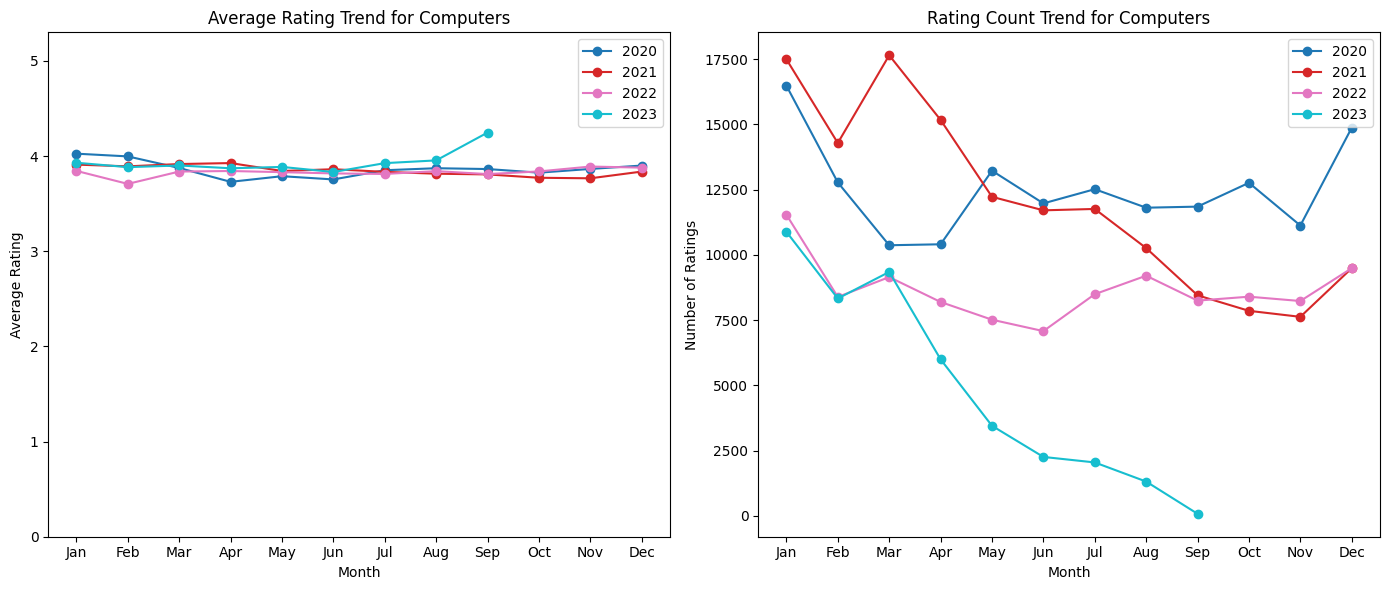

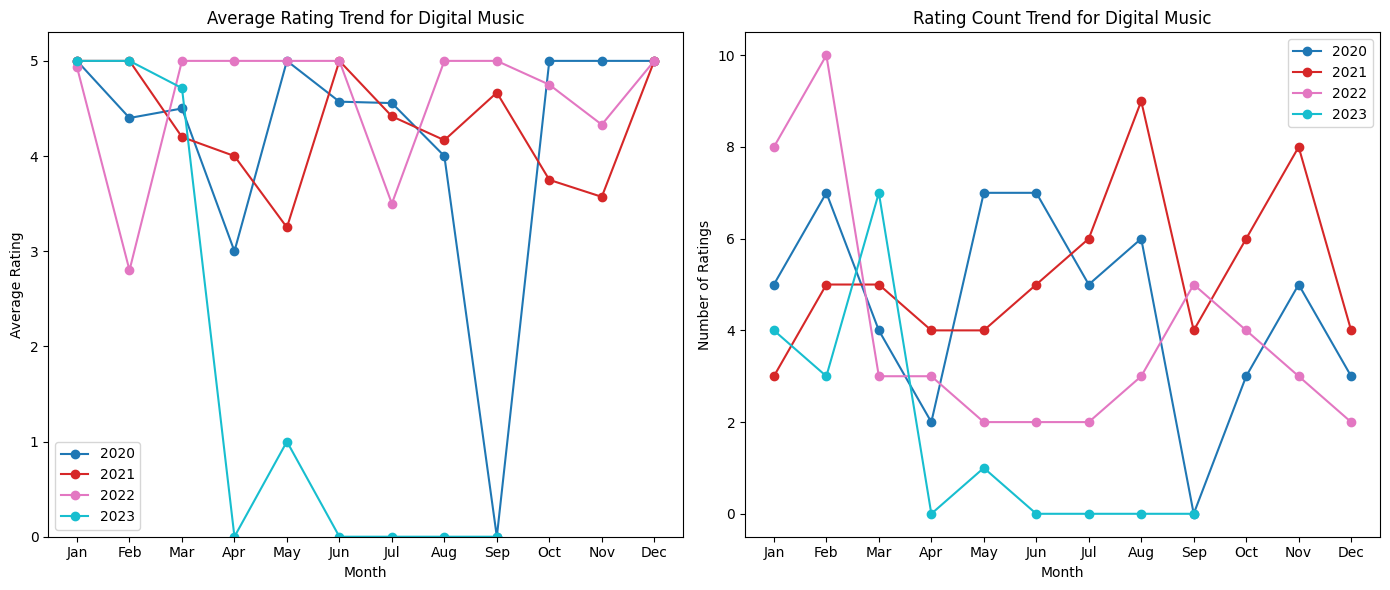

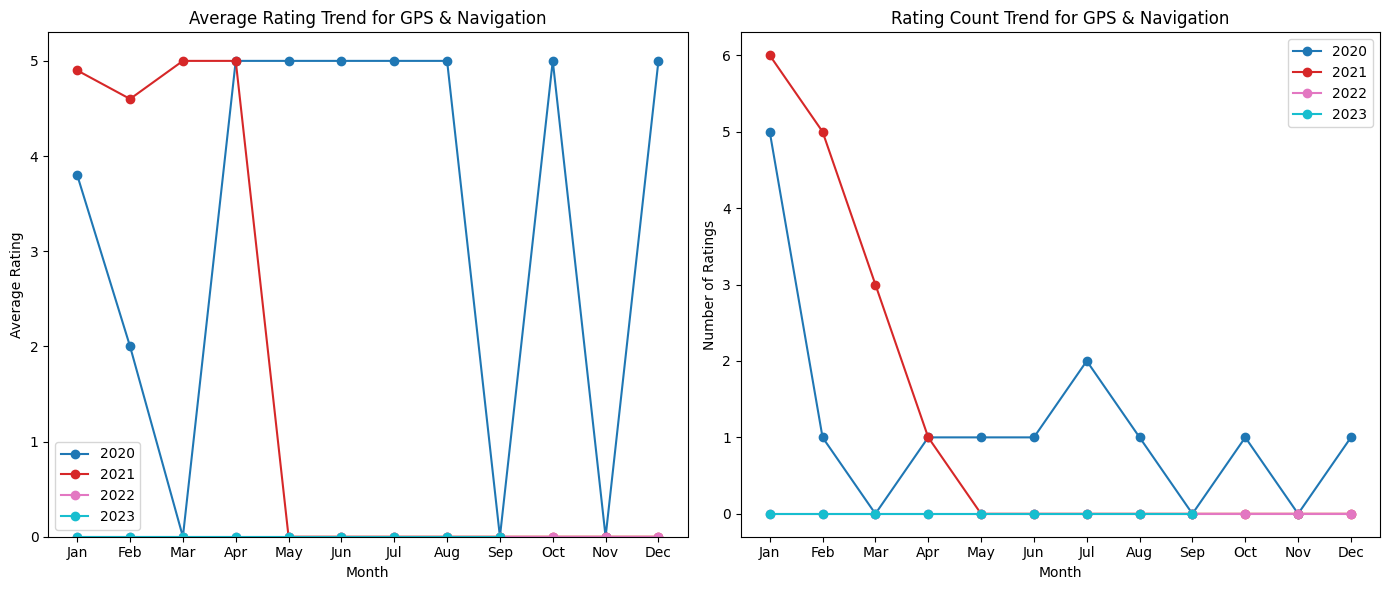

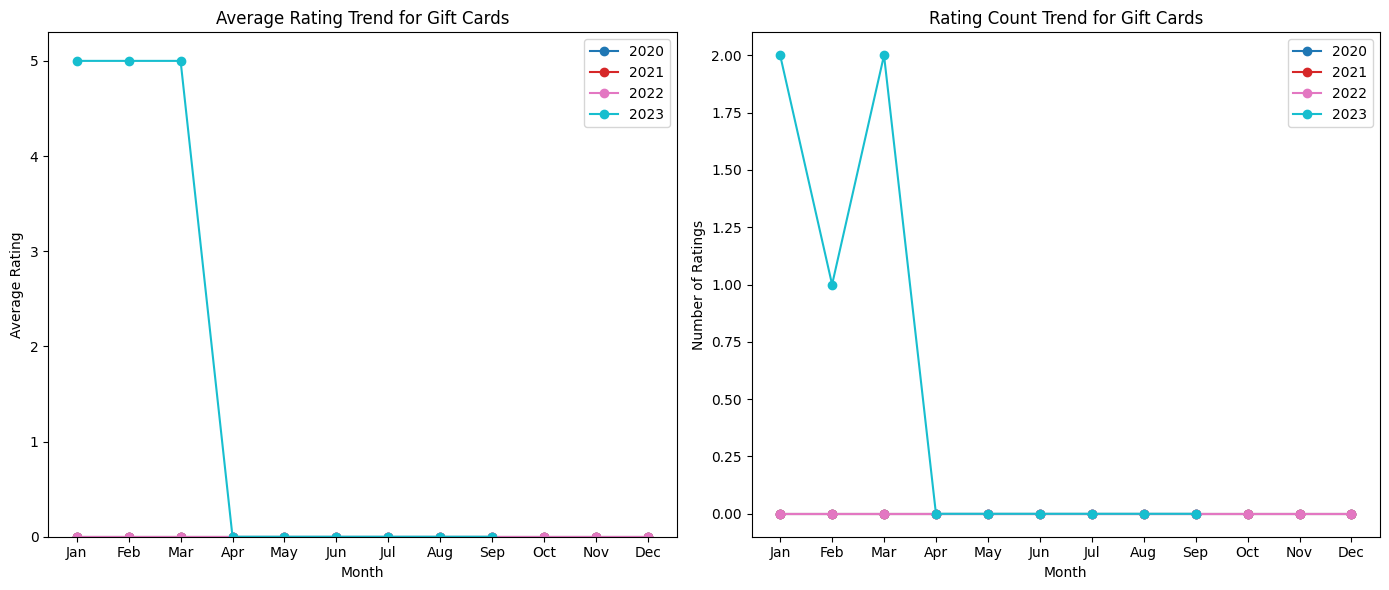

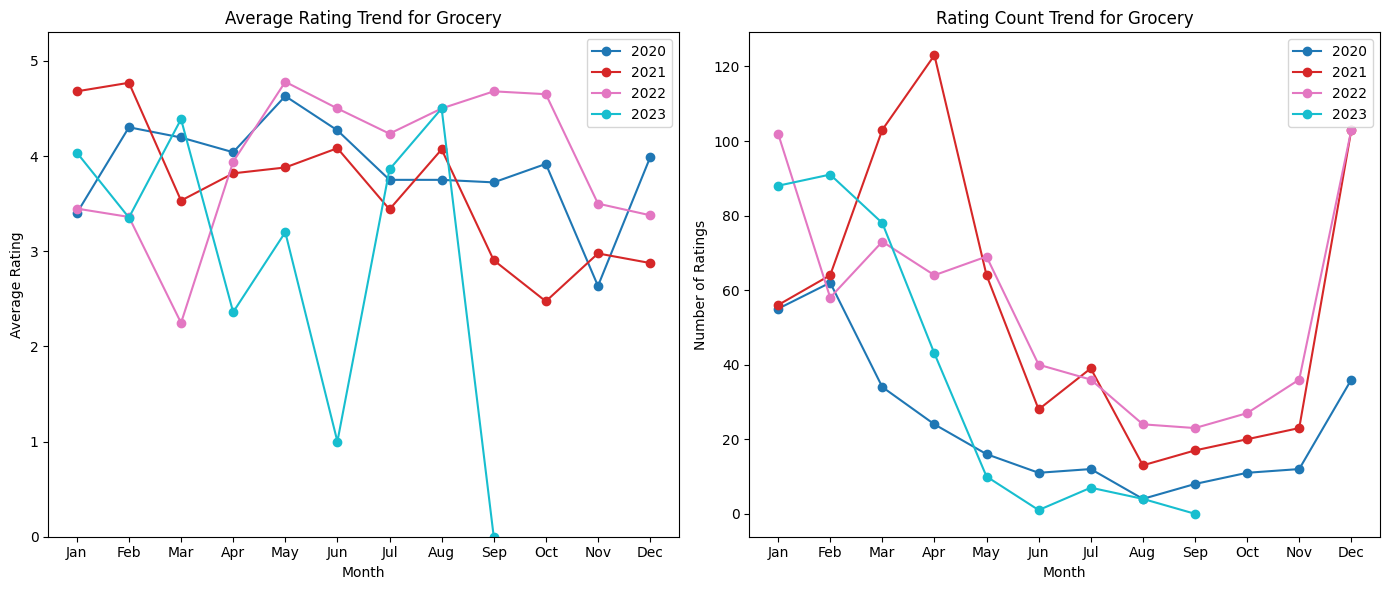

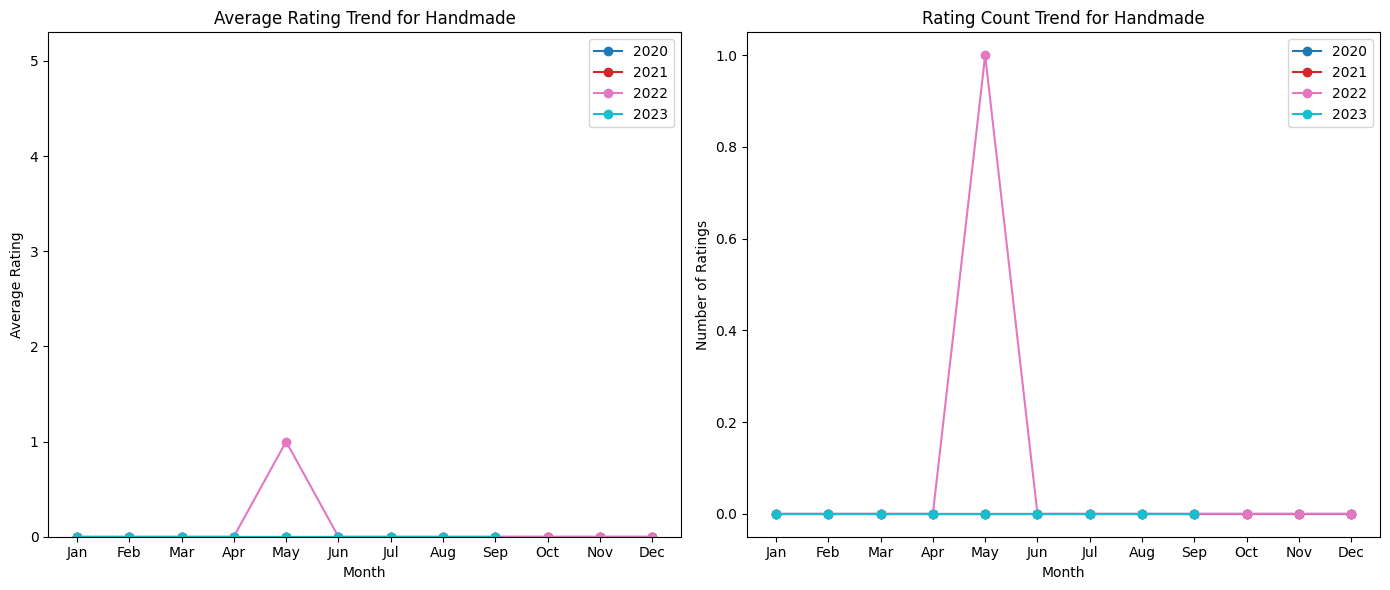

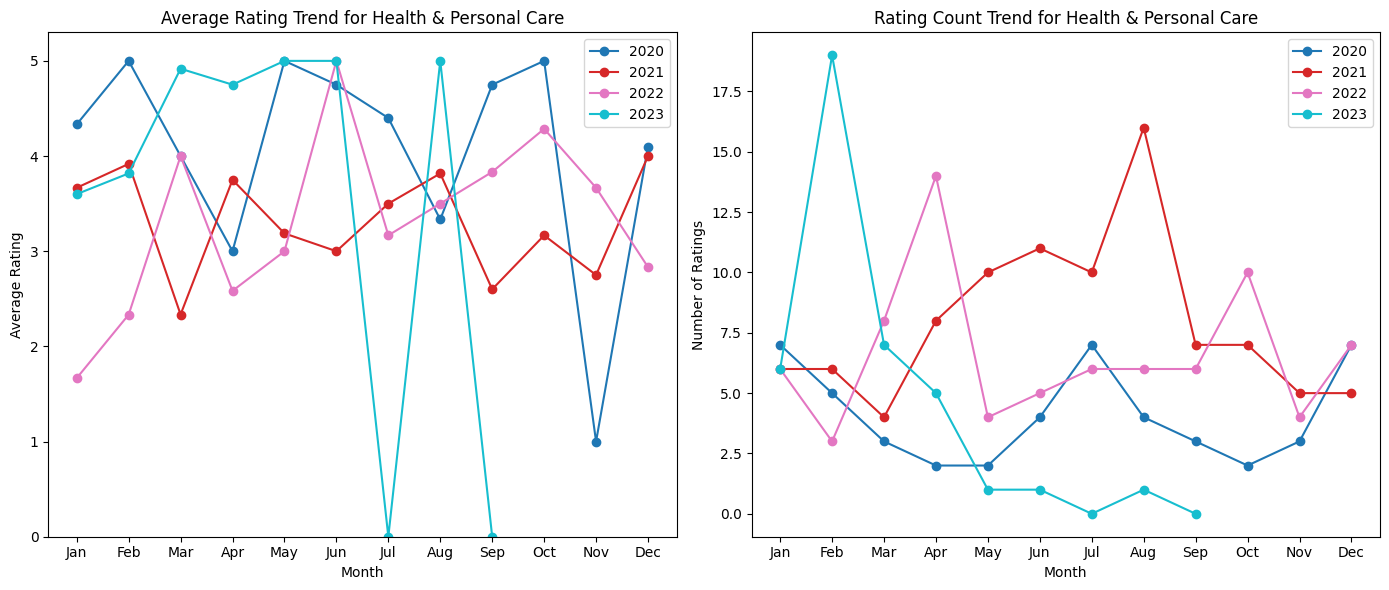

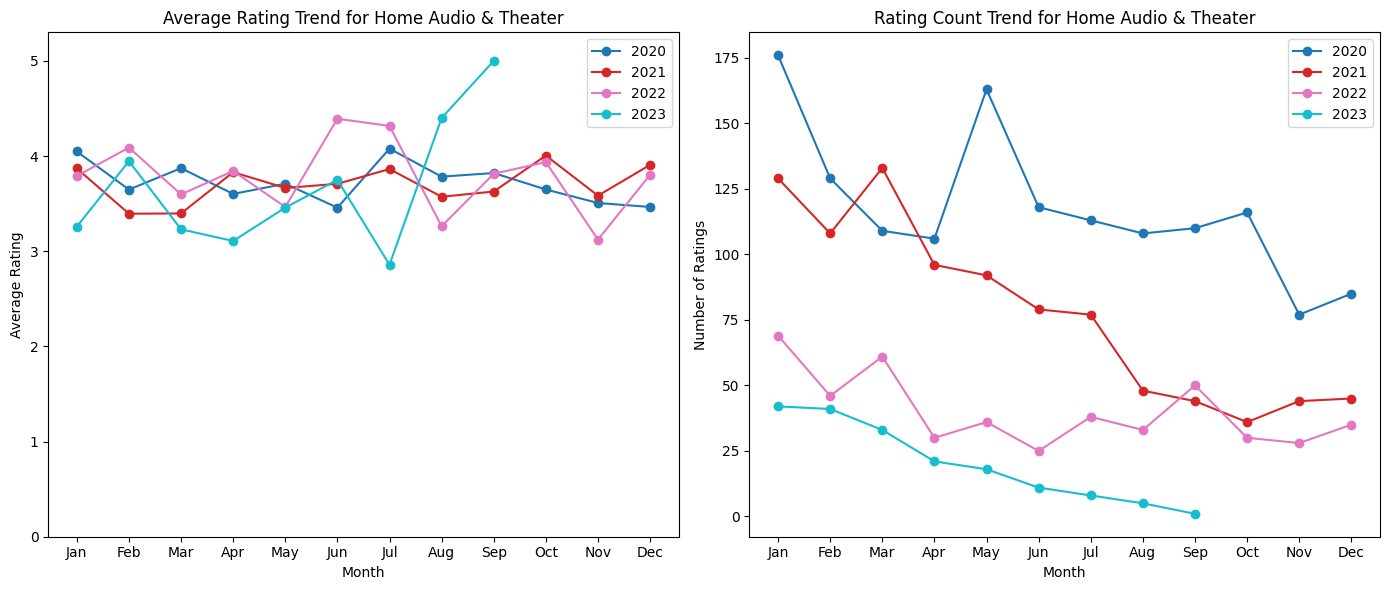

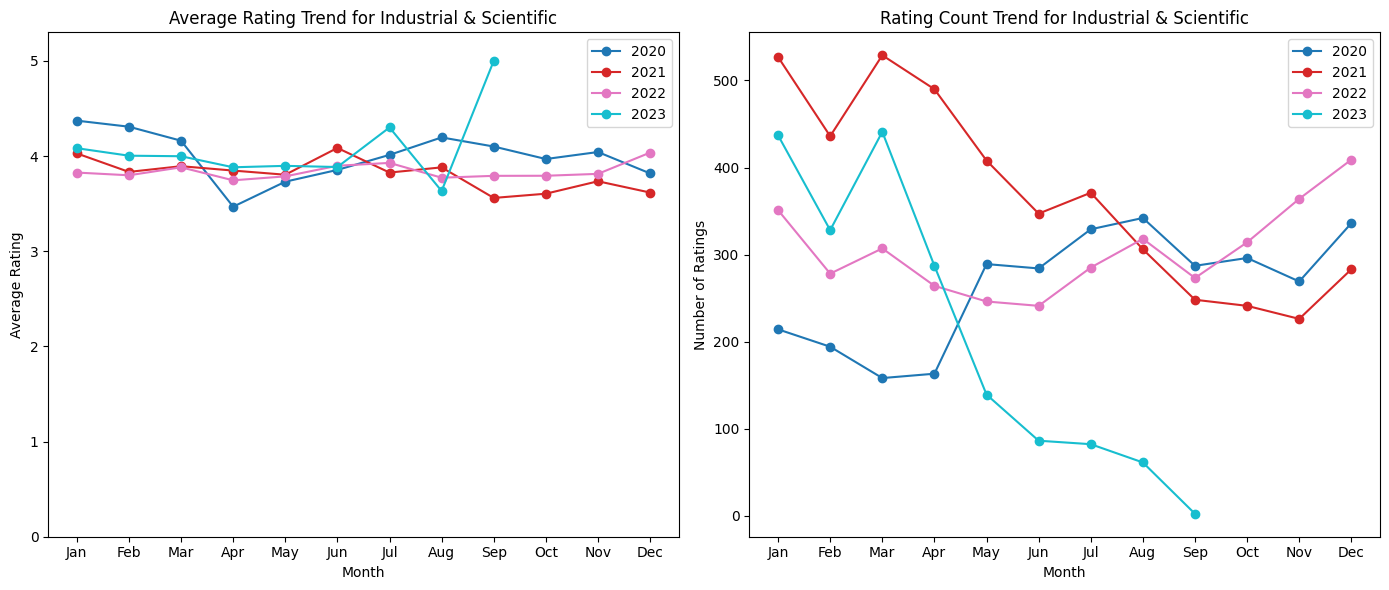

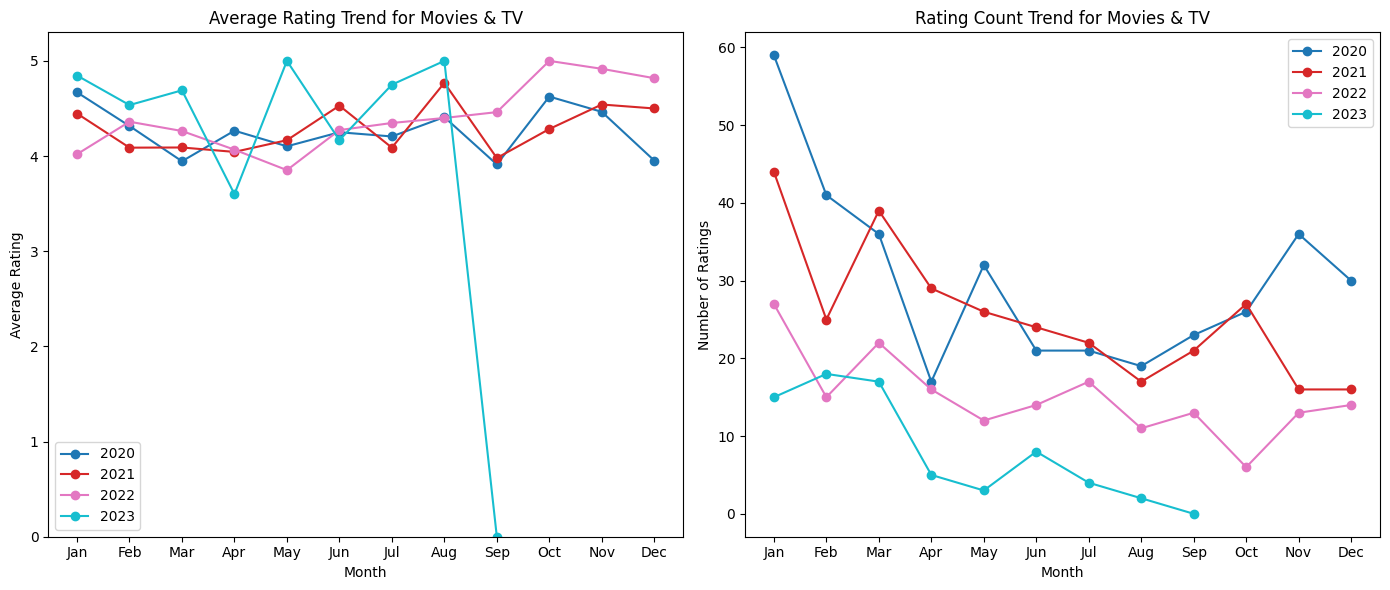

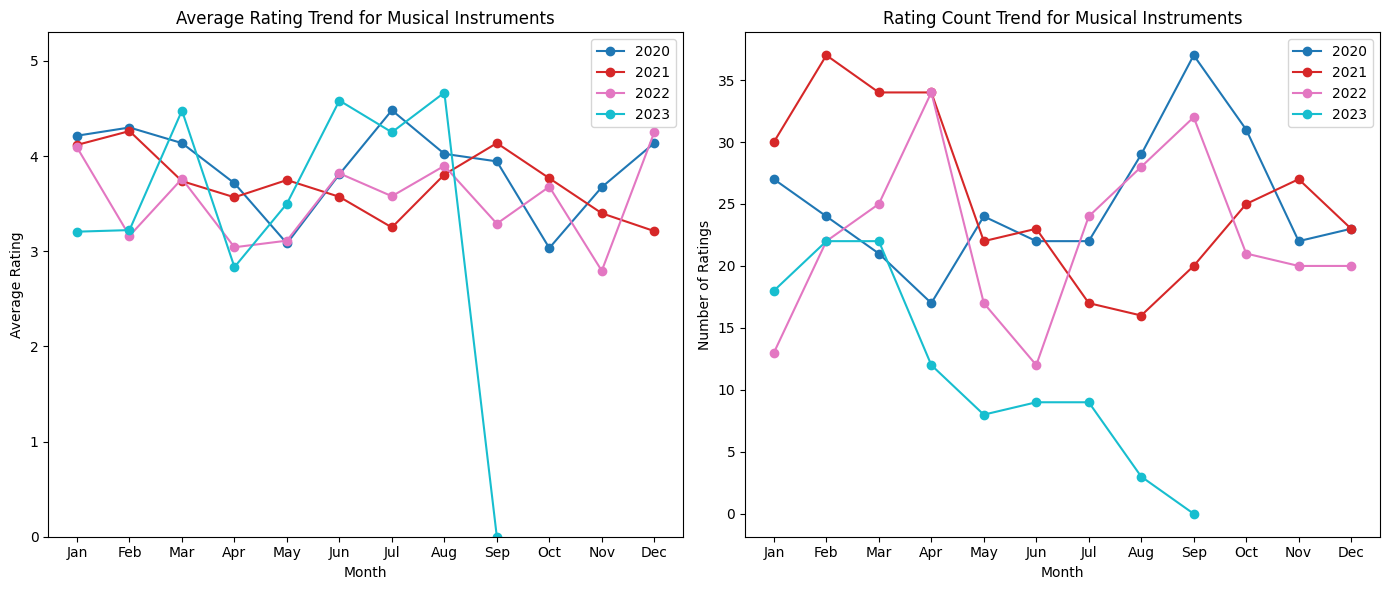

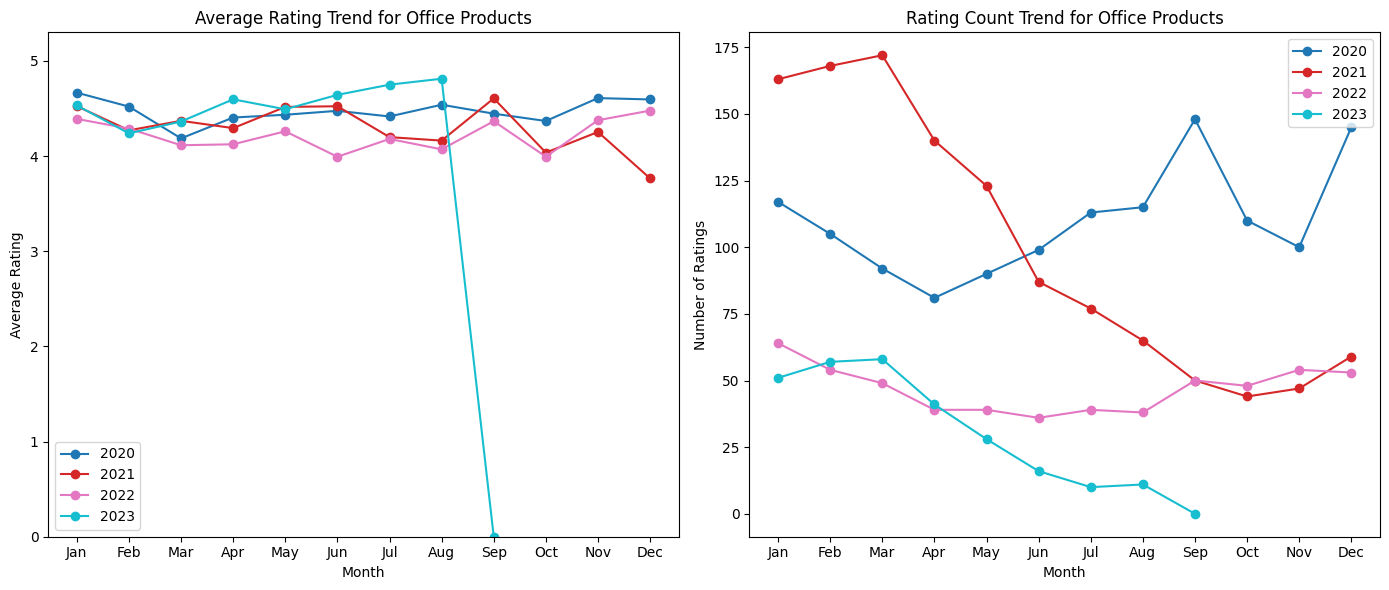

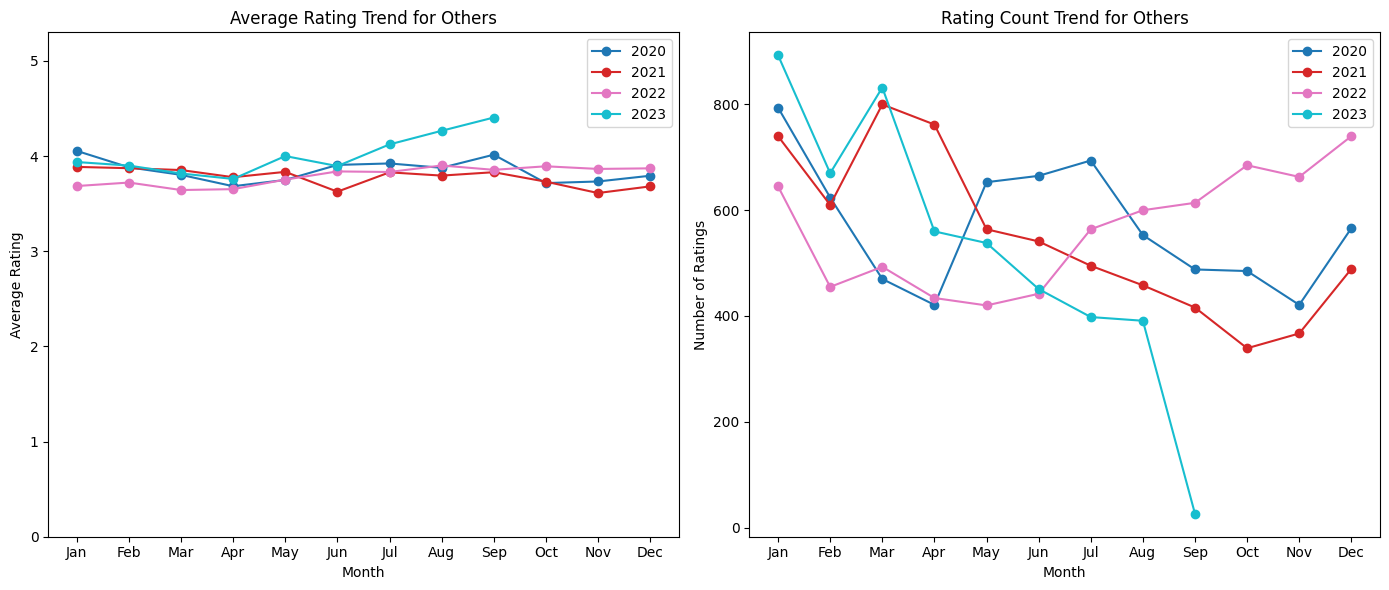

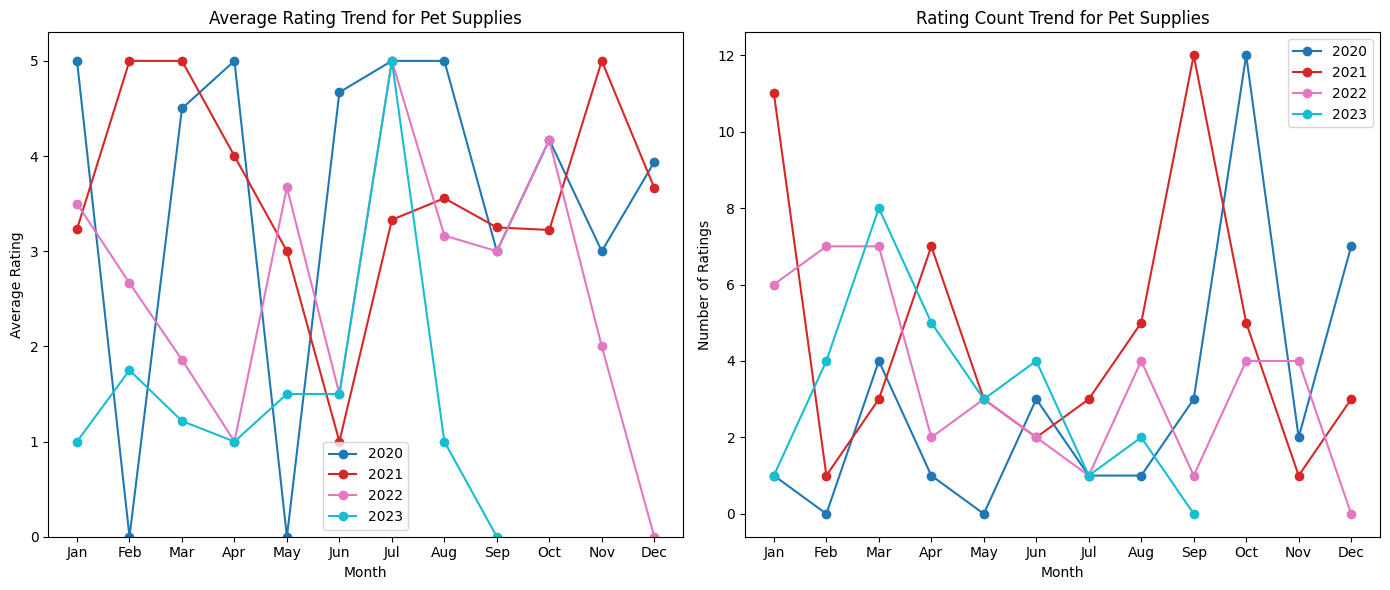

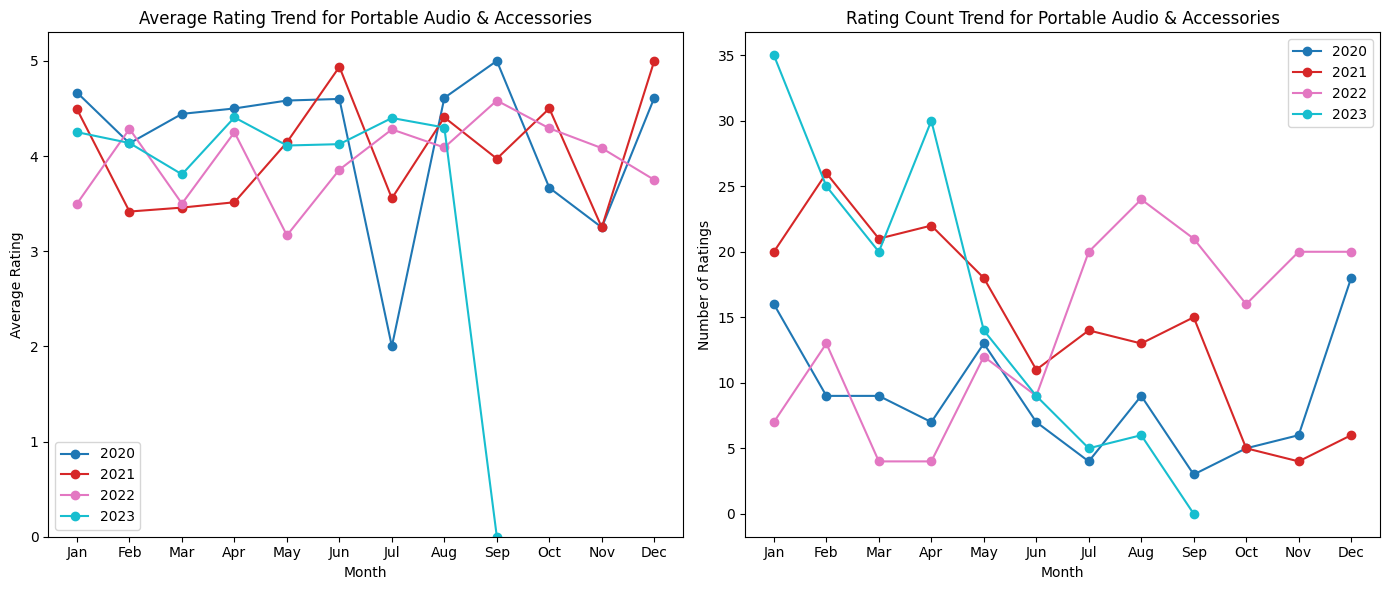

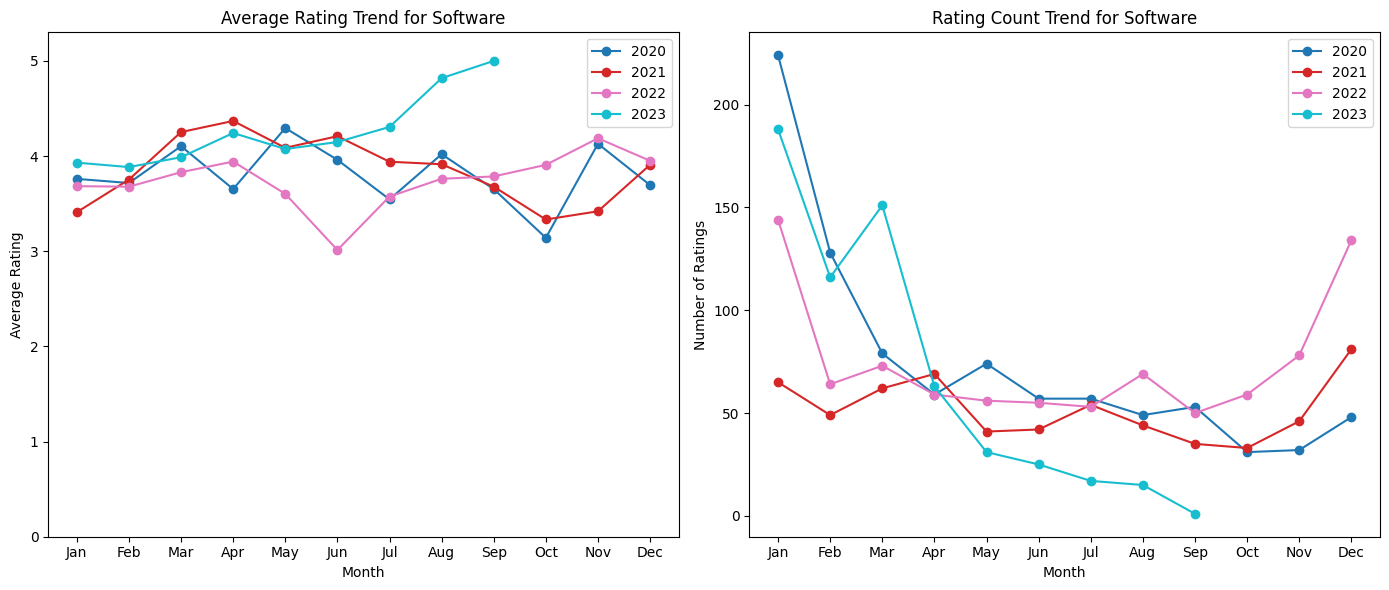

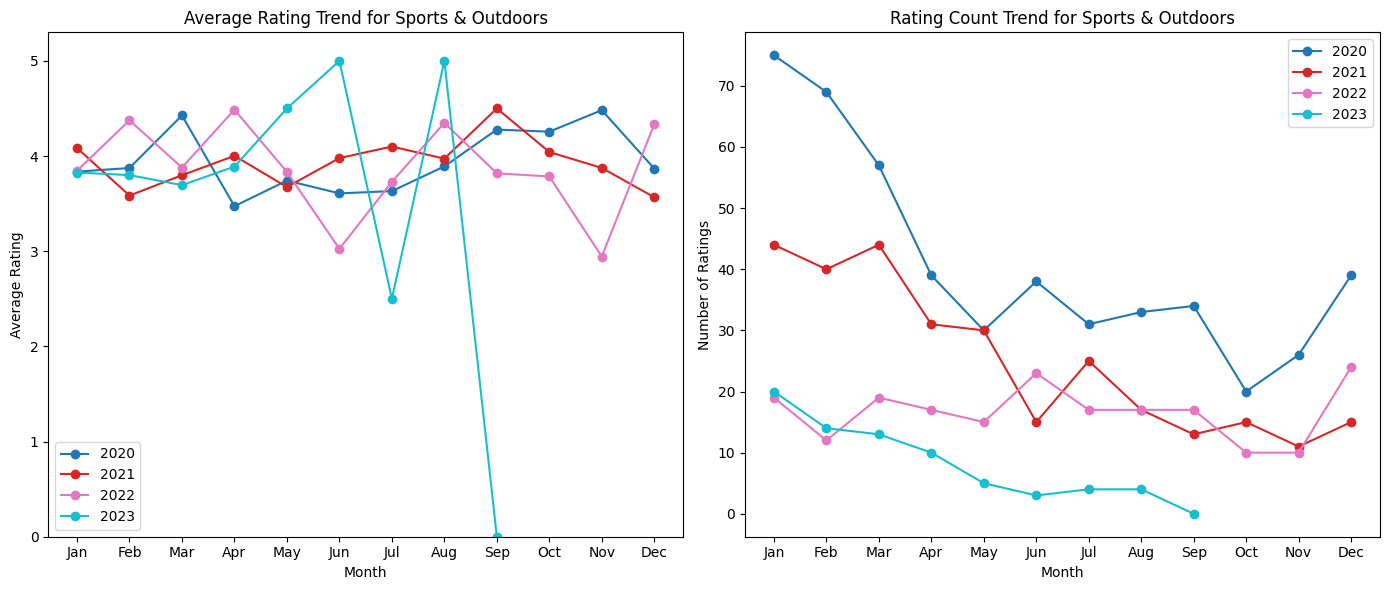

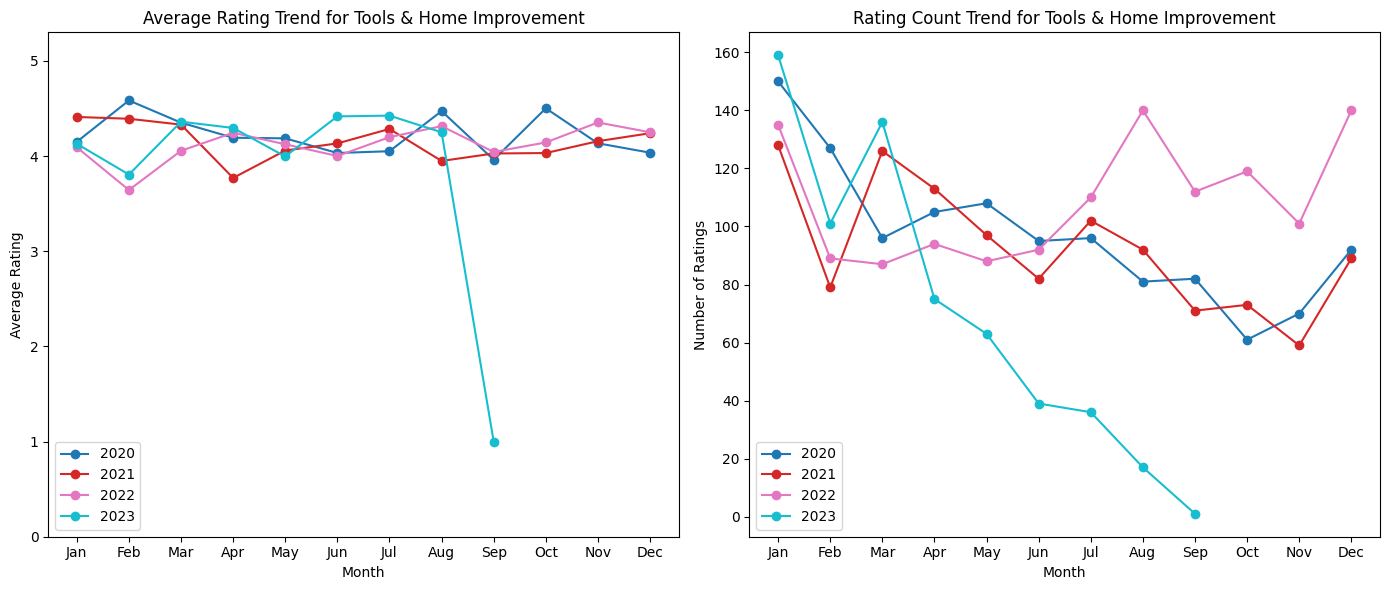

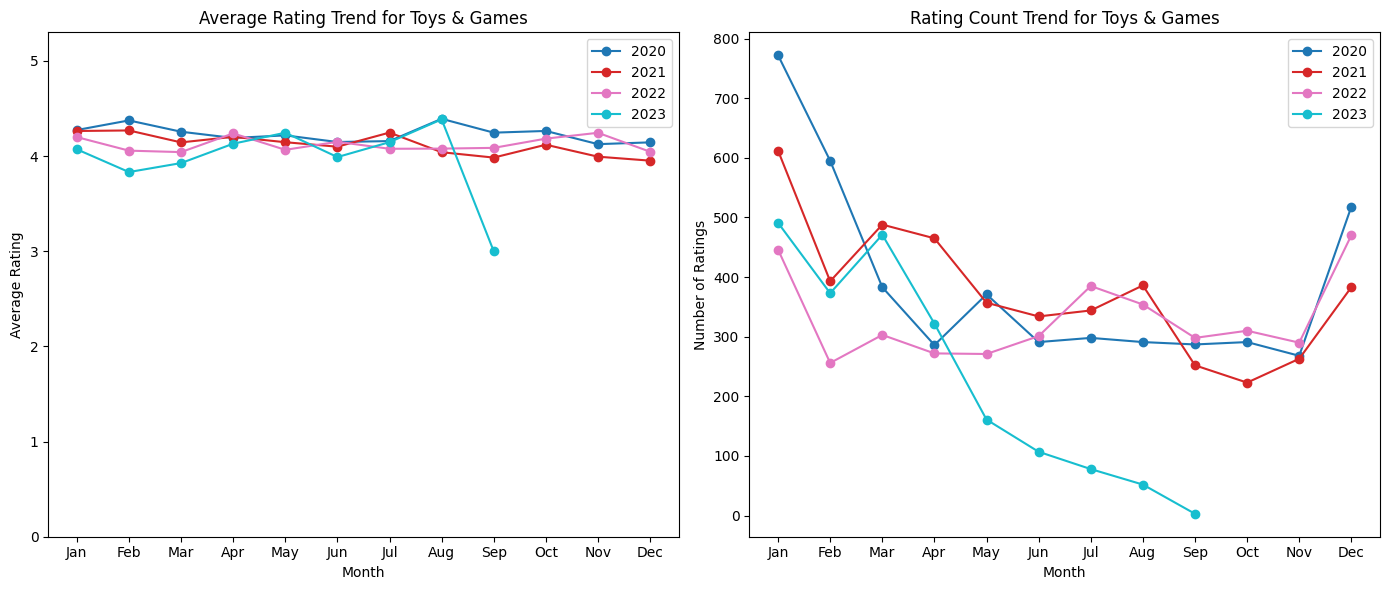

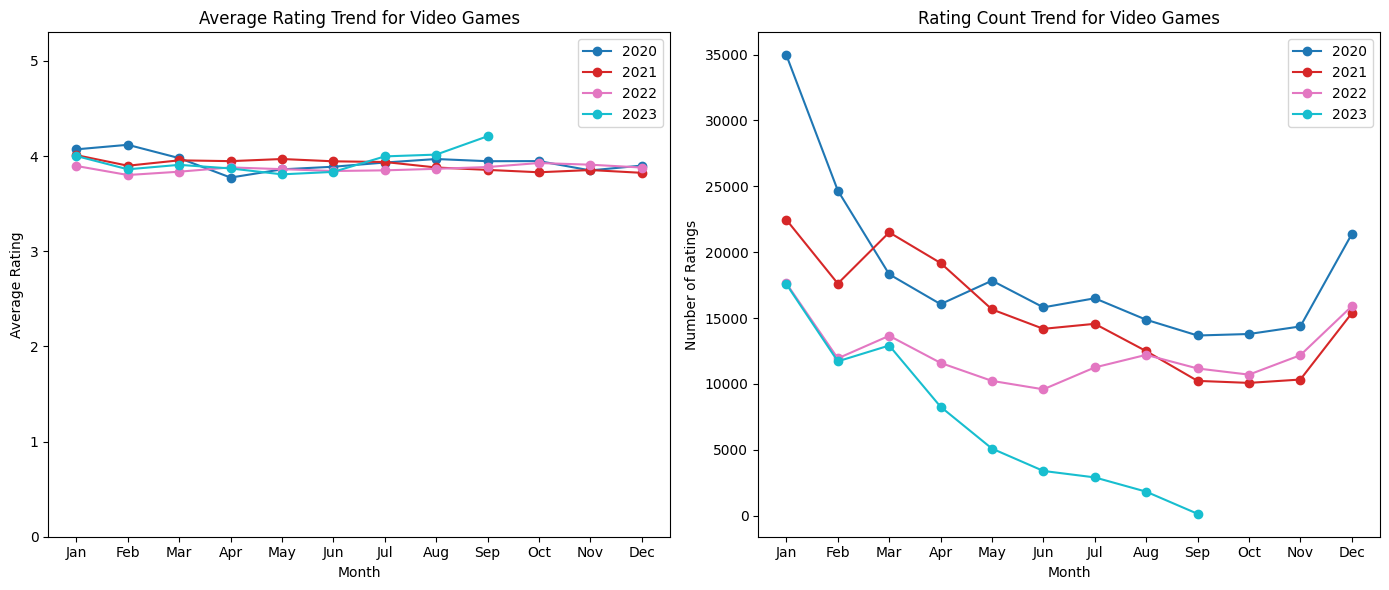

In [137]:
# Define the year range dynamically (e.g., from 2020 to 2023)
start_year = 2020
end_year = 2023
year_range = range(start_year, end_year + 1)

# Iterate through each main_category and generate individual plots
for category in unique_categories:
    category_data = agg_df[agg_df['main_category'] == category]

    # Create a DataFrame with all months
    all_months_df = pd.DataFrame({
        'month': month_names
    })
    
    # Initialize an empty DataFrame to store merged data for the years
    category_data_merged = pd.DataFrame()

    for year in year_range:
        # Filter category data for the current year
        category_data_year = category_data[category_data['year'] == year]
        
        # Merge the actual data with the all_months_df, ensuring all months are represented
        category_data_year_merged = pd.merge(all_months_df, category_data_year, on='month', how='left', suffixes=('', '_actual'))
        
        # Fill missing values (NaN) with 0 for 'average_rating' and 'rating_count'
        category_data_year_merged['average_rating'] = category_data_year_merged['average_rating'].fillna(0)
        category_data_year_merged['rating_count'] = category_data_year_merged['rating_count'].fillna(0)
        
        # Fill missing values for 'year' and 'main_category'
        category_data_year_merged['year'] = category_data_year_merged['year'].fillna(year)
        category_data_year_merged['main_category'] = category_data_year_merged['main_category'].fillna(category)

        # Concatenate the data for the current year to the merged data DataFrame
        category_data_merged = pd.concat([category_data_merged, category_data_year_merged])

    # Dynamically exclude October to December for the year 2023 due to Dataset not updated to 2023 Oct onwards.
    category_data_merged = category_data_merged[~((category_data_merged['year'] == 2023) & 
                                                  (category_data_merged['month'].isin(['Oct', 'Nov', 'Dec'])))]

    # Create a new figure for each category
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Update the colormap retrieval to use plt.get_cmap
    year_colors = {year: plt.get_cmap('tab10', len(year_range))(i) for i, year in enumerate(year_range)}


    # Left subplot: Plot average rating (line plot)
    ax1 = axes[0]
    for year in year_range:
        year_data = category_data_merged[category_data_merged['year'] == year]
        ax1.plot(year_data['month'], year_data['average_rating'], 
                 label=f'{year}', color=year_colors[year], marker='o')

    ax1.set_title(f'Average Rating Trend for {category}')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Rating')

    ax1.legend()
    ax1.set_ylim(0, 5.3)  # Set y-axis limits to 0-5 for all graphs

    # Right subplot: Plot rating count (line plot)
    ax2 = axes[1]
    for year in year_range:
        year_data = category_data_merged[category_data_merged['year'] == year]
        ax2.plot(year_data['month'], year_data['rating_count'], 
                 label=f'{year}', color=year_colors[year], marker='o')

    ax2.set_title(f'Rating Count Trend for {category}')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Number of Ratings')

    ax2.legend()

    # Adjust layout to avoid overlapping subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
# Initialize an empty DataFrame to hold merged data for all categories
all_categories_data_merged = pd.DataFrame()

# Iterate through each main_category and generate the data
for category in unique_categories:
    category_data = agg_df[agg_df['main_category'] == category]

    # Create a DataFrame with all months
    all_months_df = pd.DataFrame({
        'month': month_names
    })
    
    # Initialize an empty DataFrame to store merged data for the years
    category_data_merged = pd.DataFrame()

    for year in year_range:
        # Filter category data for the current year
        category_data_year = category_data[category_data['year'] == year]
        
        # Merge the actual data with the all_months_df, ensuring all months are represented
        category_data_year_merged = pd.merge(all_months_df, category_data_year, on='month', how='left', suffixes=('', '_actual'))
        
        # Fill missing values (NaN) with 0 for 'average_rating' and 'rating_count'
        category_data_year_merged['average_rating'] = category_data_year_merged['average_rating'].fillna(0)
        category_data_year_merged['rating_count'] = category_data_year_merged['rating_count'].fillna(0)
        
        # Fill missing values for 'year' and 'main_category'
        category_data_year_merged['year'] = category_data_year_merged['year'].fillna(year)
        category_data_year_merged['main_category'] = category_data_year_merged['main_category'].fillna(category)

        # Concatenate the data for the current year to the merged data DataFrame
        category_data_merged = pd.concat([category_data_merged, category_data_year_merged])

    # Dynamically exclude October to December for the year 2023 due to Dataset not updated to 2023 Oct onwards.
    category_data_merged = category_data_merged[~((category_data_merged['year'] == 2023) & 
                                                  (category_data_merged['month'].isin(['Oct', 'Nov', 'Dec'])))]

    # Append this category's data to the overall DataFrame
    all_categories_data_merged = pd.concat([all_categories_data_merged, category_data_merged])

# Export the full merged dataset for all categories to a CSV file
all_categories_data_merged.to_csv('all_category_data_trends.csv', index=False)

print("CSV file containing all categories' data has been saved successfully!")


CSV file has been saved successfully!
